# DSCI552 HW4

by Kartik Balodi  
Github Username: kartikbalodi  
USC ID: 5317465471

In [1]:
#pip install natsort

In [2]:
#pip install bootstrapped

In [3]:
#pip install scikit-plot

In [4]:
#pip install imbalanced-learn

In [5]:
#pip install yellowbrick

The program takes about 25 minutes to run from start to end, with cell 59 taking up around/over half the time. The other .ipynb files titled "misc_timedomainfeature1_timedomainfeature2_timedomainfeature3" are copies of this until c(ii), with the exception of me playing with other time domain features to see what kind of results show up. The commenting will likely be off for the other .ipynb files, as the commenting is relevant to this notebook's outputs - so pay attention to the outputs for the other files should you be interested in comparing the performance of other time domain features.

In [6]:
import pandas as pd
import numpy as np

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics

import statsmodels.api as sm
from yellowbrick.classifier import ROCAUC
from imblearn.over_sampling import SMOTE 

import os
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt

## Time Series Classification Part 1: Feature Creation/Extraction
  
**An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.**  

**(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29**  
  
- **The dataset contains 7 folders that represent seven types of activities.** 
- **In each folder, there are multiple files each of which represents an instant of a human performing an activity. (Some of the data files need very minor cleaning. You can do it by Excel or Python.)** 
- **Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23.** 
- **There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.**

**(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.**

In [7]:
relative_path = "../data/AReM/"
abs_path = os.path.abspath(relative_path)
abs_path = abs_path.replace('\\','/') + '/'

folder_names = []
for i in os.listdir(abs_path):
    if i.endswith('.pdf'):
        continue
    else:
        folder_names.append(i)

folder_path = [abs_path+i+'/' for i in folder_names]

#note now we have two lists folder_names and folder_path

##### Summary of issues in data that I encountered with corresponding solutions:  
- _../data/AReM/cycling/dataset9.csv_ - extra comma on last line, resolved by manually removing extra comma on line 485
- _../data/AReM/cycling/dataset14.csv_ - extra comma on last line, resolved by manually removing extra comma on line 485
- _../data/AReM/sitting/dataset8.csv_ - one line missing for when time=13500 (between lines 59 and 60 in the csv file), I manually inserted the line for time = 13500 in the .csv file, with the data values populated as NaN (empty commaspace in .csv). Then, I fill values using the interpolate method
- _../data/AReM/bending2/dataset4.csv_ - values separated by space instead of comma, code block added in the for loop to account for this file, since it only occurs for one file in the whole dataset

In [8]:
#repeating this cell with fixes for all the data issues caught and elaborated on above, in hw4 I will use just this 
#cell and omit some of the previous ones above since a lot of it served exploratory purposes and the data has been cleaned
#accordingly
#here I add in two new columns called 'activity' and 'sample', which will be used for multi-index/groupby calls in c(ii)

test_df_dict = {}
train_df_dict = {}
columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

for i in range(len(folder_names)):
    file_names = natsorted(os.listdir(folder_path[i]))
    #uses relative_path in the end to find file names
    file_path = [relative_path+folder_names[i]+'/'+j for j in file_names]
    #note now we have file_names and file_path, derived from folder_names[i] and folder_path[i]

    #keep datasets 1 and 2 for testing, rest for training
    if folder_names[i] == 'bending1' or folder_names[i] == 'bending2': 
        #test first
        test_df = pd.DataFrame()
        for j in range(0,2):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            test_df = pd.concat([test_df,df],axis=0)
        test_df_dict[folder_names[i]] = test_df
        
        #train next
        train_df = pd.DataFrame()
        for j in range(2,len(file_names)):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            #accounting for the one file that has whitespace as delimiter
            if file_path[j] == '../data/AReM/bending2/dataset4.csv':
                df = pd.read_csv(file_path[j],skiprows=5,header=None,delim_whitespace=True,names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            train_df = pd.concat([train_df,df],axis=0)
        train_df_dict[folder_names[i]] = train_df
    
    
    #keep datasets 1,2 and 3 for testing, rest for training
    else: 
        #test first
        test_df = pd.DataFrame()
        for j in range(0,3):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            test_df = pd.concat([test_df,df],axis=0)
        test_df_dict[folder_names[i]] = test_df
        
        #train next
        train_df = pd.DataFrame()
        for j in range(3,len(file_names)):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            train_df = pd.concat([train_df,df],axis=0)
        train_df_dict[folder_names[i]] = train_df 
        
#accounting for the NaN valus for t=13500 from ../data/AReM/sitting/dataset8.csv
df_temp = train_df_dict['sitting']
df_temp = df_temp.interpolate()
train_df_dict['sitting'] = df_temp

In [9]:
for name in folder_names:
    print(name)
    print("train set")
    display(train_df_dict[name].isnull().sum())
    print('test set')
    display(test_df_dict[name].isnull().sum())

bending1
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

bending2
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

cycling
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

lying
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

sitting
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

standing
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

walking
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

As desired, no more NaN values are present. Now we can piece this together into one overall test and train dataframe, with multi-indexing to separate activity and sample data corresponding to each activity.

In [10]:
train_df = pd.DataFrame()
for key in train_df_dict.keys():
    train_df = pd.concat([train_df, train_df_dict[key]],axis=0)

test_df = pd.DataFrame()
for key in test_df_dict.keys():
    test_df = pd.concat([test_df, test_df_dict[key]],axis=0)

**(c) Feature Extraction  
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.**  
  
**i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).**

_Simple statistical features_
- Means in each of the d dimensions
- Standard deviations of the d dimensions
- Skewness, Kurtosis and Higher order moments of the d dimensions
- Maximum and Minimum values + Quantiles (including Median)  
  
_Time series analysis related features_
- The d×d−1 Cross-Correlations between each dimension and the d Auto-Correlations
- Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model, more specifically the time lag component for AR and MA components and the degree of the delta subtraction operator the I component
- Parameters of the AR part
- Parameters of the MA part  
  
_Frequency domain related features_
- frequencies of the k peaks in amplitude in the Discrete Fourier Transforms (DFTs) for the detrended d dimensions
- k-quantiles of these DFTs  
  
Source: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

**ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly (You are welcome to experiment to see if they make a difference).**  

In [11]:
combined_df = pd.concat([test_df,train_df],axis=0).set_index(['activity','sample'])
combined_df

time  avg_rss12  var_rss12  avg_rss13  var_rss13  \
activity sample                                                          
bending1 dataset1        0      39.25       0.43      22.75       0.43   
         dataset1      250      39.25       0.43      23.00       0.00   
         dataset1      500      39.25       0.43      23.25       0.43   
         dataset1      750      39.50       0.50      23.00       0.71   
         dataset1     1000      39.50       0.50      24.00       0.00   
...                    ...        ...        ...        ...        ...   
walking  dataset15  118750      34.50       6.18       9.00       3.56   
         dataset15  119000      25.75       6.02      13.75       2.05   
         dataset15  119250      31.50       3.35      10.25       5.12   
         dataset15  119500      33.75       2.77      14.00       3.24   
         dataset15  119750      37.00       1.41      18.25       3.70   

                    avg_rss23  var_rss23  
activity sample                           
bending1 dataset1       33.75       1.30  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
...                       ...        ...  
walking  dataset15      12.67       4.19  
         dataset15      16.00       1.58  
         dataset15      16.25       2.95  
         dataset15      13.75       0.43  
         dataset15      11.00       4.32  

[42240 rows x 7 columns]

In [12]:
#drop time axis from table format
desc_df = combined_df.drop('time',axis=1).groupby(['activity', 'sample']).describe()

#change labels of 25%, 50%, 75% to quartiles and medians
desc_df = desc_df.rename(columns=dict(zip(desc_df.columns.levels[1], 
                        ['count','mean','std','min','first quartile','median','third quartile','max'])), level=1)

#drop count from describe() call
tuple1 = ('avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23')
drop_cols = [(i, 'count') for i in tuple1]
desc_df = desc_df.drop('count',axis=1,level=1)

#re-order columns to fit the presentation format
tuple2 = ('min','max','mean','median','std','first quartile','third quartile')
new_order_list = [(i,j) for i in tuple1 for j in tuple2]
desc_df = desc_df[new_order_list]

In [13]:
#using feature data directly
desc_df

avg_rss12                                      \
                        min    max       mean  median       std   
activity sample                                                   
bending1 dataset1     37.25  45.00  40.624792  40.500  1.476967   
         dataset2     38.00  45.67  42.812812  42.500  1.435550   
         dataset3     35.00  47.40  43.954500  44.330  1.558835   
         dataset4     33.00  47.75  42.179813  43.500  3.670666   
         dataset5     33.00  45.75  41.678063  41.750  2.243490   
...                     ...    ...        ...     ...       ...   
walking  dataset5     20.75  46.25  34.763333  35.290  4.742208   
         dataset6     21.50  51.00  34.935813  35.500  4.645944   
         dataset7     18.33  47.67  34.333042  34.750  4.948770   
         dataset8     18.33  45.75  34.599875  35.125  4.731790   
         dataset9     15.50  43.67  34.225875  34.750  4.441798   

                                                var_rss12                   \
                  first quartile third quartile       min    max      mean   
activity sample                                                              
bending1 dataset1          39.25        42.0000       0.0   1.30  0.358604   
         dataset2          42.00        43.6700       0.0   1.22  0.372438   
         dataset3          43.00        45.0000       0.0   1.70  0.426250   
         dataset4          39.15        45.0000       0.0   3.00  0.696042   
         dataset5          41.33        42.7500       0.0   2.83  0.535979   
...                          ...            ...       ...    ...       ...   
walking  dataset5          31.67        38.2500       0.0  12.68  4.223792   
         dataset6          32.00        38.0625       0.0  12.21  4.115750   
         dataset7          31.25        38.0000       0.0  12.48  4.396958   
         dataset8          31.50        38.0000       0.0  15.37  4.398833   
         dataset9          31.25        37.2500       0.0  17.24  4.354500   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ...  2.188449        33.0000          36.00       0.0   
         dataset2  ...  1.995255        32.0000          34.50       0.0   
         dataset3  ...  1.999604        35.3625          36.50       0.0   
         dataset4  ...  3.849448        30.4575          36.33       0.0   
         dataset5  ...  2.411026        28.4575          31.25       0.0   
...                ...       ...            ...            ...       ...   
walking  dataset5  ...  3.174681        14.2500          18.33       0.0   
         dataset6  ...  3.192058        14.2375          18.25       0.0   
         dataset7  ...  3.000493        13.7500          18.00       0.0   
         dataset8  ...  2.905688        14.0000          18.25       0.0   
         dataset9  ...  2.992920        14.3300          18.25       0.0   

                                                                    \
                     max      mean median       std first quartile   
activity sample                                                      
bending1 dataset1   1.92  0.570583  0.430  0.582915           0.00   
         dataset2   3.11  0.571083  0.430  0.601010           0.00   
         dataset3   1.79  0.493292  0.430  0.513506           0.00   
         dataset4   2.18  0.613521  0.500  0.524317           0.00   
         dataset5   1.79  0.383292  0.430  0.389164           0.00   
...                  ...       ...    ...       ...            ...   
walking  dataset5   9.39  3.288271  3.270  1.647528           2.05   
         dataset6  10.21  3.280021  3.015  1.700918           2.12   
         dataset7   8.01  3.261583  2.980  1.617290           2.05   
         dataset8   8.86  3.289542  3.015  1.680170           2.12   
         da

In [14]:
#using min-max normalization on features
minmax_normalized_df=(desc_df-desc_df.min())/(desc_df.max()-desc_df.min())
minmax_normalized_df

avg_rss12                                          \
                        min       max      mean    median       std   
activity sample                                                       
bending1 dataset1  0.776042  0.571429  0.685196  0.684211  0.188828   
         dataset2  0.791667  0.596952  0.778537  0.768421  0.183415   
         dataset3  0.729167  0.662857  0.827242  0.845474  0.199526   
         dataset4  0.687500  0.676190  0.751534  0.810526  0.475507   
         dataset5  0.687500  0.600000  0.730129  0.736842  0.288999   
...                     ...       ...       ...       ...       ...   
walking  dataset5  0.432292  0.619048  0.435147  0.464842  0.615539   
         dataset6  0.447917  0.800000  0.442505  0.473684  0.602959   
         dataset7  0.381875  0.673143  0.416791  0.442105  0.642533   
         dataset8  0.381875  0.600000  0.428174  0.457895  0.614177   
         dataset9  0.322917  0.520762  0.412219  0.442105  0.576280   

                                                var_rss12                      \
                  first quartile third quartile       min       max      mean   
activity sample                                                                 
bending1 dataset1       0.647355       0.563636       NaN  0.051755  0.076911   
         dataset2       0.758186       0.624364       NaN  0.046996  0.079939   
         dataset3       0.798489       0.672727       NaN  0.075550  0.091715   
         dataset4       0.643325       0.672727       NaN  0.152885  0.150758   
         dataset5       0.731184       0.590909       NaN  0.142772  0.115729   
...                          ...            ...       ...       ...       ...   
walking  dataset5       0.341864       0.427273       NaN  0.728733  0.922797   
         dataset6       0.355164       0.420455       NaN  0.700773  0.899152   
         dataset7       0.324937       0.418182       NaN  0.716835  0.960694   
         dataset8       0.335013       0.418182       NaN  0.888757  0.961104   
         dataset9       0.324937       0.390909       NaN  1.000000  0.951402   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ...  0.072449       0.931248       0.983849       0.0   
         dataset2  ...  0.040816       0.902146       0.935395       0.0   
         dataset3  ...  0.041529       1.000000       1.000000       0.0   
         dataset4  ...  0.344411       0.857257       0.994509       0.0   
         dataset5  ...  0.108892       0.799054       0.830413       0.0   
...                ...       ...            ...            ...       ...   
walking  dataset5  ...  0.233929       0.385595       0.413066       0.0   
         dataset6  ...  0.236774       0.385231       0.410482       0.0   
         dataset7  ...  0.205408       0.371044       0.402407       0.0   
         dataset8  ...  0.189886       0.378319       0.410482       0.0   
         dataset9  ...  0.204168       0.387923       0.410482       0.0   

                                                                          \
                        max      mean    median       std first quartile   
activity sample                                                            
bending1 dataset1  0.010998  0.059510  0.000000  0.123495       0.000000   
         dataset2  0.111675  0.059669  0.000000  0.134981       0.000000   
         dataset3  0.000000  0.034952  0.000000  0.079434       0.000000   
         dataset4  0.032995  0.073153  0.024055  0.086297       0.000000   
         dataset5  0.000000  0.000000  0.000000  0.000503       0.000000   
...                     ...       ...       ...       ...            ...   
walking  dataset5  0.642978  0.923034  0.975945  0.799305       0.915179   
         dataset6  0.712352  0.920412  0.888316  0.833197      

In [15]:
#using mean normalization/z-stats on features
mean_normalized_df=(desc_df-desc_df.mean())/desc_df.std()
mean_normalized_df

avg_rss12                                          \
                        min       max      mean    median       std   
activity sample                                                       
bending1 dataset1  0.858236 -0.107653  0.320006  0.302073 -0.853155   
         dataset2  0.936606  0.044815  0.730077  0.669717 -0.876526   
         dataset3  0.623125  0.438501  0.944049  1.006110 -0.806959   
         dataset4  0.414139  0.518148  0.611442  0.853538  0.384715   
         dataset5  0.414139  0.063020  0.517406  0.531850 -0.420618   
...                     ...       ...       ...       ...       ...   
walking  dataset5 -0.865907  0.176802 -0.778530 -0.655638  0.989370   
         dataset6 -0.787536  1.257733 -0.746204 -0.617035  0.935050   
         dataset7 -1.118781  0.499943 -0.859174 -0.754901  1.105930   
         dataset8 -1.118781  0.063020 -0.809165 -0.685968  0.983491   
         dataset9 -1.414497 -0.410314 -0.879258 -0.754901  0.819853   

                                                var_rss12                      \
                  first quartile third quartile       min       max      mean   
activity sample                                                                 
bending1 dataset1       0.362418       0.156216       NaN -0.985657 -0.699103   
         dataset2       0.809311       0.481187       NaN -1.001459 -0.690315   
         dataset3       0.971818       0.739996       NaN -0.906648 -0.656130   
         dataset4       0.346167       0.739996       NaN -0.649870 -0.484744   
         dataset5       0.700432       0.302161       NaN -0.683448 -0.586424   
...                          ...            ...       ...       ...       ...   
walking  dataset5      -0.869384      -0.573508       NaN  1.262143  1.756279   
         dataset6      -0.815756      -0.609995       NaN  1.169307  1.687645   
         dataset7      -0.937636      -0.622157       NaN  1.222638  1.866284   
         dataset8      -0.897010      -0.622157       NaN  1.793477  1.867475   
         dataset9      -0.937636      -0.768102       NaN  2.162843  1.839312   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ... -1.316513       3.144976       3.158473   -0.1066   
         dataset2  ... -1.505019       2.980947       2.887310   -0.1066   
         dataset3  ... -1.500775       3.532496       3.248861   -0.1066   
         dataset4  ...  0.304175       2.727931       3.218129   -0.1066   
         dataset5  ... -1.099337       2.399872       2.299789   -0.1066   
...                ...       ...            ...            ...       ...   
walking  dataset5  ... -0.354216       0.069424      -0.035832   -0.1066   
         dataset6  ... -0.337261       0.067373      -0.050294   -0.1066   
         dataset7  ... -0.524177      -0.012591      -0.095488   -0.1066   
         dataset8  ... -0.616681       0.028416      -0.050294   -0.1066   
         dataset9  ... -0.531566       0.082546      -0.050294   -0.1066   

                                                                          \
                        max      mean    median       std first quartile   
activity sample                                                            
bending1 dataset1 -1.803126 -0.909413 -0.934685 -0.899806      -1.189080   
         dataset2 -1.330701 -0.908980 -0.934685 -0.864846      -1.189080   
         dataset3 -1.854735 -0.976345 -0.934685 -1.033913      -1.189080   
         dataset4 -1.699907 -0.872230 -0.870257 -1.013025      -1.189080   
         dataset5 -1.854735 -1.071602 -0.934685 -1.274156      -1.189080   
...                     ...       ...       ...       ...            ...   
walking  dataset5  1.162430  1.444029  1.679275  1.157149       1.513324   
         dataset6  1.487966  1.436885  1.444570  1.260305      

**iii. Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python’s bootstrapped or any other
method to build a 90% bootstrap confidence interval for the standard deviation
of each feature.**  
  
Resources consulted:
- https://pypi.org/project/bootstrapped/
- https://github.com/facebookarchive/bootstrapped/blob/master/bootstrapped/bootstrap.py (search for 'def bootstrap')

In [16]:
feature_stdev_list = desc_df.std()
bootstrap_list = [] #in case I need to use this in future parts of the assignment
for i in range(len(feature_stdev_list)):
    col_name = (tuple1[i//7],tuple2[i%7])

    #bs.bootstrap(samples, stat_func=bs_stats.std)
    ret = np.array([])
    ret = bs.bootstrap(desc_df[col_name].to_numpy(), stat_func=bs_stats.std, alpha=0.1, num_iterations=10000)
    bootstrap_list.append((col_name,ret)) #in case I need to use this in future parts of the assignment
    print(col_name)
    print(ret)
    print()

('avg_rss12', 'min')
9.515445066931841    (8.322106107213783, 10.84174794021971)

('avg_rss12', 'max')
4.36932238296287    (3.4862500608086755, 5.427337915998034)

('avg_rss12', 'mean')
5.305300142199838    (4.764031104006244, 5.934217614993763)

('avg_rss12', 'median')
5.409056425357996    (4.84824309881242, 6.047382958628967)

('avg_rss12', 'std')
1.7620574921772343    (1.5816473743381452, 1.963085983346162)

('avg_rss12', 'first quartile')
6.118526249454473    (5.623947952592536, 6.686519925477826)

('avg_rss12', 'third quartile')
5.109642753365408    (4.403380863162641, 5.91167260446285)

('var_rss12', 'min')
0.0    (0.0, 0.0)

('var_rss12', 'max')
5.033881679163113    (4.687378130252301, 5.4807355646921145)

('var_rss12', 'mean')
1.565199957842158    (1.4345574643647148, 1.741328248692937)

('var_rss12', 'median')
1.4041971241720508    (1.2735440976299084, 1.5750195680431587)

('var_rss12', 'std')
0.8790661169601129    (0.8219789971980872, 0.9607762340940043)

('var_rss12', 'first

**iv. Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).**  
  
From studying the mean-normalized and min-max-normalized data in detail, I believe that mean, standard deviation and the range (i.e. max-min), represent the three most important time-domain features.  

The reason I back these features is that the mean and standard deviation gives us an intuition for the spread of the time-series feature. Adding the range information on top gives us a feeling for outliers and skewness, given the assumption that the time-series features follow some form of normal/Symmetric Alpha-Stable distribution. If we incude the IQR, we might have some intuition for the kurtosis as well, but I reason that this is not as crucial because the range under mean/z-stat normalization has a max-min value <= 2 in most cases based on the observed data, so the spread across features does not warrant a deeper analysis of kurtosis behavior as of now.  
  
If max and min count as two time-domain features in my justification above, I would like to substitute that with the median. The closer the median is to the mean, in general the more symmetric our curve. If median < mean, it is likely that the data has a longer right-tail, and if median > mean, it is likely that the data has a longer left-tail - which gives us some intuition about the general skewness of the time-series data.  
  
Thus,
- mean
- standard deviation
- range = (max-min), or median (if range counts as two time-domain features)

## 2. Time Series Classification Part 2: Binary and Multiclass Classification
  
**(a) Binary Classification Using Logistic Regression  
(Some logistic regression packages have a built-in L2 regularization. To remove the effect of L2 regularization, set λ = 0 or set the budget C → ∞ (i.e. a very large value).)**  
  
**i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).  
(You are welcome to repeat this experiment with other features as well as with time series 3, 4, and 5 in each instance.)**

In [17]:
train_df

time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0         0      42.00       0.71      21.25       0.43      30.00       0.00   
1       250      41.50       0.50      20.25       1.48      31.25       1.09   
2       500      41.50       0.50      14.25       1.92      33.00       0.00   
3       750      40.75       0.83      15.75       0.43      33.00       0.00   
4      1000      40.00       0.71      20.00       2.74      32.75       0.43   
..      ...        ...        ...        ...        ...        ...        ...   
475  118750      34.50       6.18       9.00       3.56      12.67       4.19   
476  119000      25.75       6.02      13.75       2.05      16.00       1.58   
477  119250      31.50       3.35      10.25       5.12      16.25       2.95   
478  119500      33.75       2.77      14.00       3.24      13.75       0.43   
479  119750      37.00       1.41      18.25       3.70      11.00       4.32   

     activity     sample  
0    bending1   dataset3  
1    bending1   dataset3  
2    bending1   dataset3  
3    bending1   dataset3  
4    bending1   dataset3  
..        ...        ...  
475   walking  dataset15  
476   walking  dataset15  
477   walking  dataset15  
478   walking  dataset15  
479   walking  dataset15  

[33120 rows x 9 columns]

In [18]:
def get_instance_stats_binary_classification_bending(df, stats_type_list, describe_df, bending_status):
    for i in range(0,len(df),480):
        instance_stats = df.iloc[i:i+480].describe()
        instance_df = pd.DataFrame()
        for j in stats_type_list:
            single_stats = pd.DataFrame(data=[instance_stats.loc[j].tolist()],
                                        columns=[j+"_"+str(i) for i in instance_stats.columns])
            instance_df = pd.concat([instance_df,single_stats],axis=1)
        instance_df['bending_status'] = bending_status
        describe_df = pd.concat([describe_df,instance_df],ignore_index=True)
    return describe_df

In [19]:
stats_type_list = ['min','std','max']

describe_df = pd.DataFrame()
train_df_bending = train_df.loc[(train_df['activity'] == 'bending1') | (train_df['activity'] == 'bending2')].drop(
    ['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
describe_df = get_instance_stats_binary_classification_bending(
    train_df_bending, stats_type_list, describe_df, bending_status='bending')

train_df_not_bending = train_df.loc[(train_df['activity'] != 'bending1') & (train_df['activity'] != 'bending2')].drop(
['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
describe_df = get_instance_stats_binary_classification_bending(
    train_df_not_bending, stats_type_list, describe_df, bending_status='not_bending')

describe_df

min_avg_rss12  min_var_rss12  min_var_rss23  std_avg_rss12  std_var_rss12  \
0           35.00            0.0           0.00       1.558835       0.338690   
1           33.00            0.0           0.00       3.670666       0.630860   
2           33.00            0.0           0.00       2.243490       0.405469   
3           37.00            0.0           0.00       1.386098       0.315566   
4           36.25            0.0           0.00       1.618364       0.263111   
..            ...            ...            ...            ...            ...   
64          19.50            0.0           0.00       4.650935       2.461077   
65          19.75            0.0           0.00       4.752477       2.599284   
66          19.50            0.0           0.00       4.842294       2.360448   
67          23.50            0.0           0.00       4.531720       2.435437   
68          19.25            0.0           0.43       4.796705       2.388746   

    std_var_rss23  max_avg_rss12  max_var_rss12  max_var_rss23 bending_status  
0        0.513506          47.40           1.70           1.79        bending  
1        0.524317          47.75           3.00           2.18        bending  
2        0.389164          45.75           2.83           1.79        bending  
3        0.622534          48.00           1.58           5.26        bending  
4        0.487826          48.00           1.50           2.96        bending  
..            ...            ...            ...            ...            ...  
64       1.640243          45.33          14.67           8.32    not_bending  
65       1.732727          45.50          13.47           9.67    not_bending  
66       1.656742          46.00          12.47          10.00    not_bending  
67       1.690960          46.25          14.82           9.51    not_bending  
68       1.699114          44.00          13.86           9.00    not_bending  

[69 rows x 10 columns]

Text(0.5, 0.98, 'Time Domain Features')

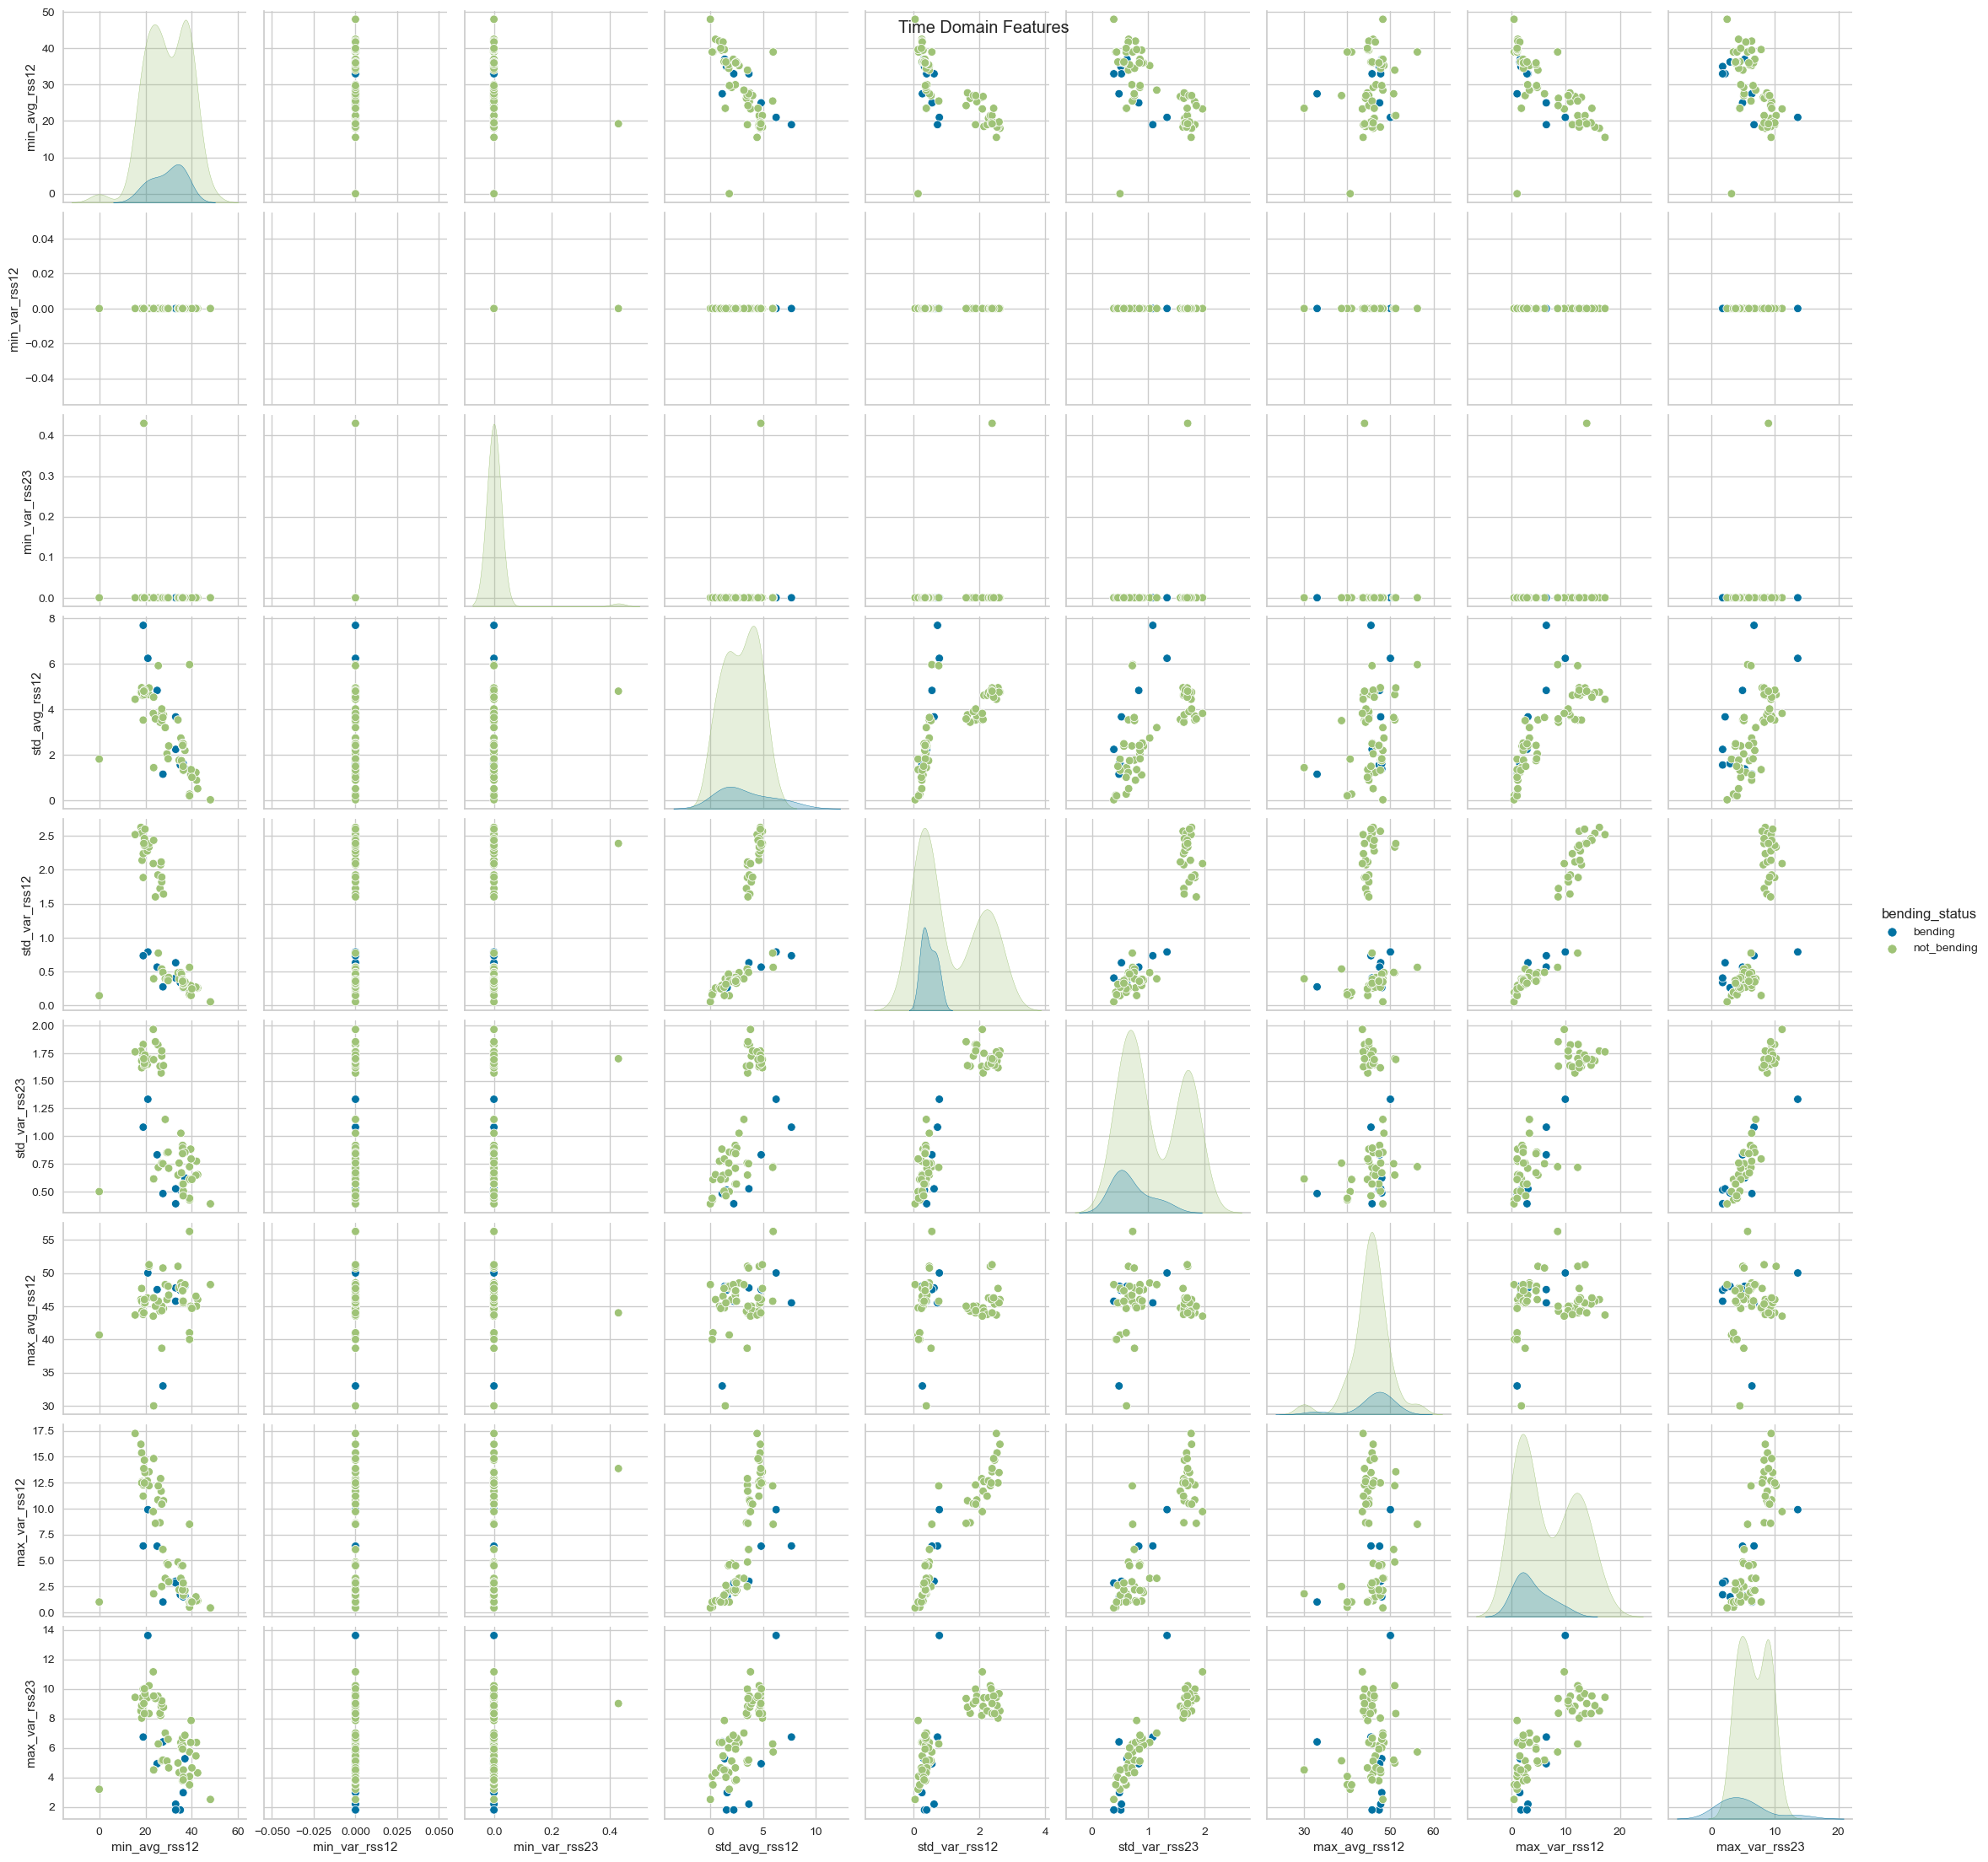

In [20]:
ax = sns.pairplot(describe_df, hue='bending_status')
ax.fig.suptitle("Time Domain Features")

**ii. Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?**

Each time series has exactly 480 points, so here I will redesign my function get_instance_stats_binary_classification_bending to account for k splits of the 480-point time series moving forward. Note that when k does not divide perfectly with 480 (as in the case of prime numbers for example), I will have the remainder terms of the time series in the kth (final) split of the time series)

In [21]:
def get_instance_stats_binary_classification_bending_ksplits(
    input_df, stats_type_list, return_df, bending_status, k_splits):
    
    describe_df = pd.DataFrame()
    step_size = 480//k_splits #note here that k_splits must be a divisor of 480
    
    #first split the dataframe into equal length time series
    splitted_input_df_list = [pd.DataFrame() for j in range(k_splits)]
    for i in range(0,len(input_df),480):
        for j in range(k_splits):
            df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < i+(j+1)*step_size) ]
            if j == k_splits-1:
                df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < 480) ]
            splitted_input_df_list[j] = pd.concat([splitted_input_df_list[j],df],axis=0)
    
    #repeat step from a(i) with each split df
    for i in range(len(splitted_input_df_list)): #for each equal-length i= to i=k time-series
        split_df = splitted_input_df_list[i]
        
        #accounts for any uneven splitting for the final split of the initial time series
        step_size2 = 480//k_splits
        if i == k_splits-1:
            step_size2 = 480//k_splits + 480%k_splits
        
        temp_df = pd.DataFrame()

        for j in range(0,len(split_df), step_size2): #for each of the j instances in the equal-length time series
            instance_stats = split_df.iloc[j:j+step_size2].describe()
            instance_df = pd.DataFrame()
            
            for k in stats_type_list: #for each stat we demand
                single_stats = pd.DataFrame(data=[instance_stats.loc[k].tolist()],
                                            columns=[k+"_"+str(l+i*6) for l in [1,2,6]]) #label ith split as 'split_i'
                instance_df = pd.concat([instance_df,single_stats],axis=1) #concat each stat by column
            
            temp_df = pd.concat([temp_df,instance_df],ignore_index=True) #concat here by row corresponding to each instance
            
        describe_df = pd.concat([describe_df,temp_df],axis=1) #concat by column to append results of each instance columnwise
    
    describe_df['bending_status'] = bending_status
    return_df = pd.concat([return_df,describe_df],ignore_index=True)
    
    return return_df

In [22]:
describe_df = pd.DataFrame()

describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending, stats_type_list, describe_df, bending_status='bending', k_splits=2)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending, stats_type_list, describe_df, bending_status='not_bending', k_splits=2)

describe_df

min_1  min_2  min_6     std_1     std_2     std_6  max_1  max_2  max_6  \
0   36.50    0.0   0.00  1.556971  0.329540  0.526656  46.50   1.50   1.79   
1   33.75    0.0   0.00  3.473355  0.634285  0.554542  47.75   3.00   1.53   
2   33.00    0.0   0.00  3.118644  0.489595  0.411200  45.75   2.83   1.79   
3   39.00    0.0   0.00  1.359836  0.314099  0.718016  48.00   1.30   5.26   
4   36.67    0.0   0.00  1.281976  0.284434  0.486847  45.00   1.30   2.28   
..    ...    ...    ...       ...       ...       ...    ...    ...    ...   
64  19.50    0.0   0.00  4.874433  2.196206  1.637310  45.00  11.78   8.29   
65  20.33    0.0   0.47  4.872880  2.762730  1.703098  44.50  13.47   8.41   
66  19.50    0.0   0.00  4.758757  2.391804  1.619767  43.33  12.47  10.00   
67  24.33    0.0   0.00  4.272282  2.341763  1.781928  44.00  14.82   9.18   
68  19.25    0.0   0.43  4.634209  2.396878  1.737420  44.00  13.86   9.00   

    min_7  min_8  min_12     std_7     std_8    std_12  max_7  max_8  max_12  \
0   35.00   0.00    0.00  1.557168  0.342346  0.478528  47.40   1.70    1.50   
1   33.00   0.00    0.00  3.537481  0.627915  0.491873  46.00   2.86    2.18   
2   39.25   0.00    0.00  0.595920  0.273050  0.363144  43.67   1.12    1.50   
3   37.00   0.00    0.00  1.058792  0.260761  0.473445  46.50   1.58    4.06   
4   36.25   0.00    0.00  1.771251  0.235493  0.487918  48.00   1.50    2.96   
..    ...    ...     ...       ...       ...       ...    ...    ...     ...   
64  22.25   0.00    0.43  4.411903  2.694219  1.646023  45.33  14.67    8.32   
65  19.75   0.00    0.00  4.621400  2.387460  1.758379  45.50  12.50    9.67   
66  20.25   0.00    0.00  4.880650  2.315929  1.691050  46.00  12.28    8.64   
67  23.50   0.43    0.00  4.785599  2.514203  1.598536  46.25  12.26    9.51   
68  20.75   0.00    0.43  4.923609  2.381634  1.657578  43.33  12.97    8.26   

   bending_status  
0         bending  
1         bending  
2         bending  
3         bending  
4         bending  
..            ...  
64    not_bending  
65    not_bending  
66    not_bending  
67    not_bending  
68    not_bending  

[69 rows x 19 columns]

Text(0.5, 0.98, 'Time Domain Features')

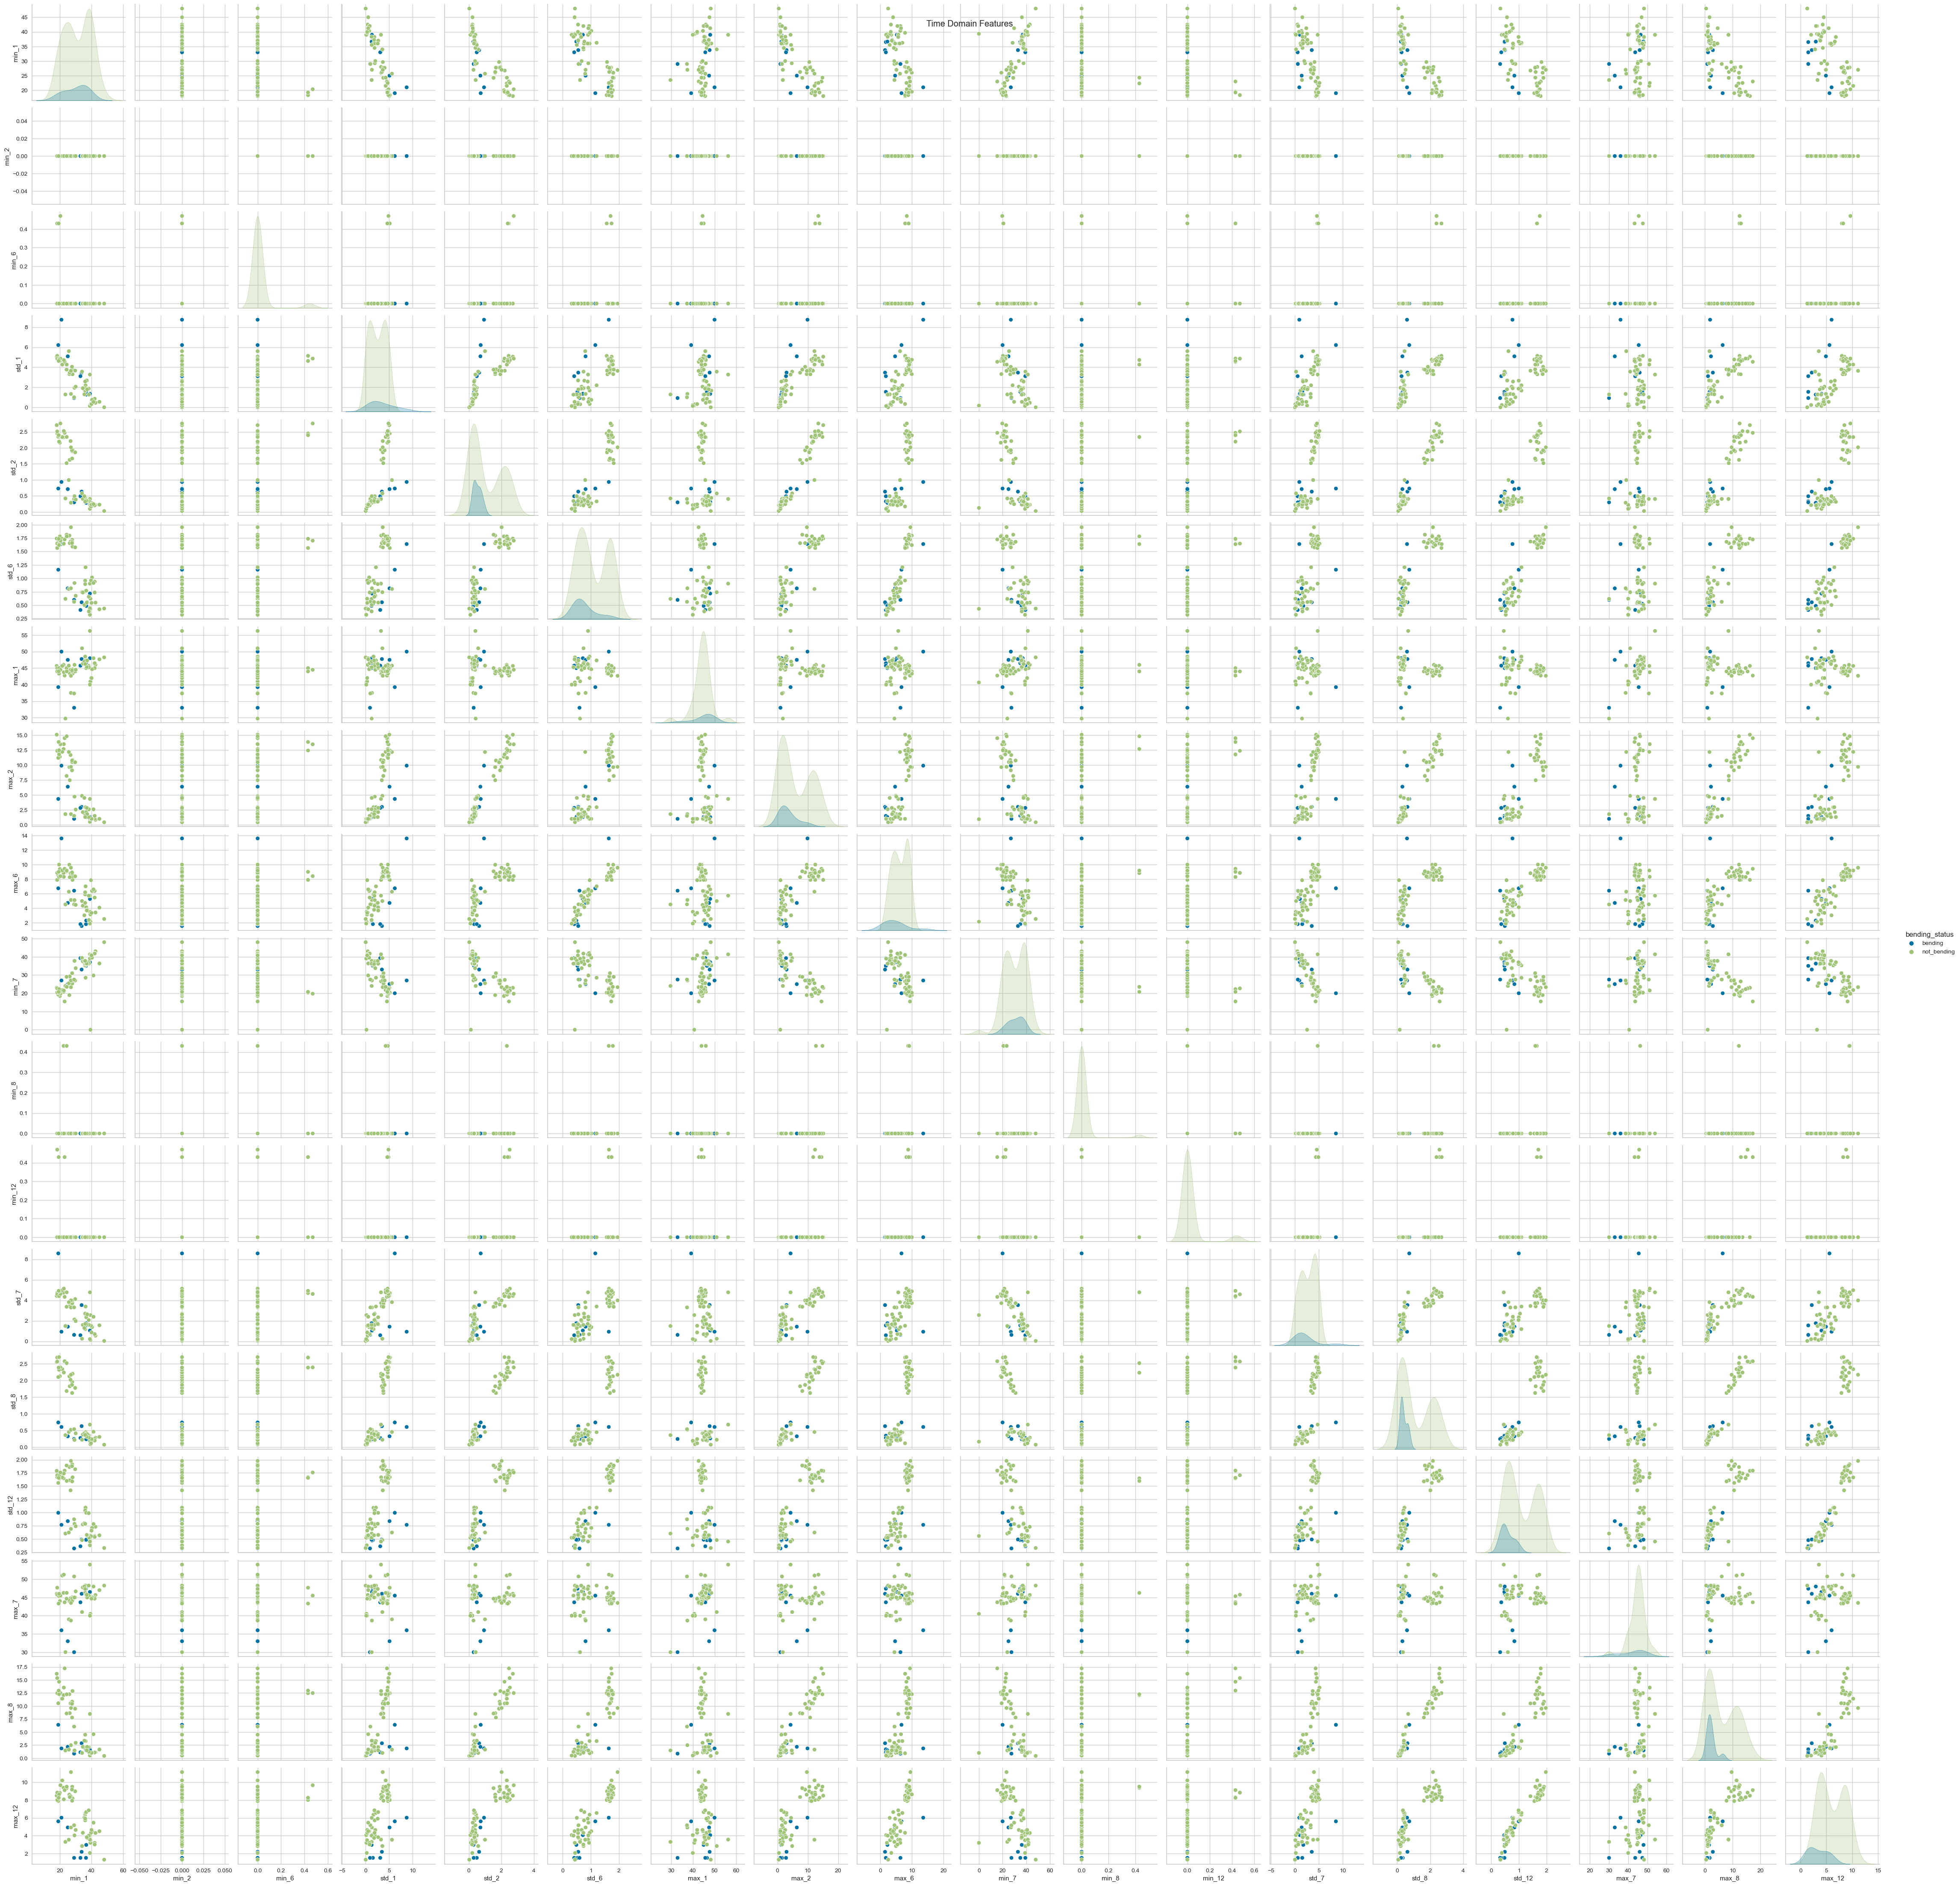

In [23]:
ax = sns.pairplot(describe_df, hue='bending_status')
ax.fig.suptitle("Time Domain Features")

**Do you see any considerable difference in the results with those of 2(a)i?**  

There are more features present (twice the amount than before) so we are able to find more ways to split the 69 samples into separable groups, apart from that the scatterplots individually seem fairly similar to me.
<!-- The data points are more sparse in this situation and since bending has fewer datapoints than not bending in the training set, the bending class stands out more visibly than before in this situation. -->

**iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
of approximately equal length and use logistic regression (If you encountered instability of the logistic regression problem because of linearly separable classes, modify the Max-Iter parameter in logistic regression to stop the algorithm immaturely and prevent from its instability.) to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance.**  
  
**Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. (R calculates the p-values for logistic regression automatically. One way of calculating them in Python is to call R within Python. There are other ways to obtain the p-values as well.) Alternatively, you can use backward selection using sklearn.feature selection or glm in R.**  
  
**Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. (This is an interesting problem in which the number of features changes depending on the value of the parameter l that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.) Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.**

Notes: 
- I played around with the max_iter parameter in increments of 100. The more max_iters I ran, the fewer failed to converge warnings I got. Eventually, I settled on max_iter=1000 for the assignment.
- I ran RFE instead of RFECV below (even though some comments on Piazza suggested otherwise), because I called the StratifiedKFolds outside the second/inner for loop. I felt that in order to correctly perform cross-validation especially with SMOTE for resampling later on, it was important that I call StratifiedKfolds first then run RFE on each - at which point it would be redundant to call cross-validation a second time in the inner for loop (through using RFECV).
- from piazza @764: "ROC and AUC is a good measure to evaluate your model post training. The goal here is to choose the l,p while training the model. Which is why, we use Cross validation. So i think CV score is the better measure to pick l,p." Thus, I will use argmax(mean_accuracy_from_5-fold_cross-val) for best L in determining the best (L,P) pair  
  
Main Resources Consulted:
- Lesson 3 Classification Lecture Notes
- Lesson 4 Resampling Lecture Notes
- https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
- https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- https://stats.stackexchange.com/questions/254124/why-does-logistic-regression-become-unstable-when-classes-are-well-separated
- https://www.quora.com/scikit-learn-How-does-RFECV-make-use-of-cross-validation
- https://www.ibm.com/support/pages/it-safe-interpret-my-logistic-regression-results-when-maximum-iterations-have-been-reached
- https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy
- https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [24]:
#I'm changing up the values here to see if there's any significant difference between our selected features
stats_type_list = ['min','std','max']

In [25]:
#these lists will give us the best results for all choices of l from 1 to 20
accuracy_list = []
best_features_byaccuracy = []
best_features_bysetsize = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)
    train_X = describe_df.drop('bending_status',axis=1)
    train_y = describe_df['bending_status']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    selected_features_folds = []
    accuracy_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #run first logistic regression with recursive feature elimination
        #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
        lrm_one = LogisticRegression(penalty='none', max_iter=1000) 
        selector = RFE(estimator=lrm_one)
        selector = selector.fit(X_train,y_train)
        best_features = selector.fit(X_train,y_train).support_
        
        #run second logistic regression with prunes set of features
        #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
        lrm_two = LogisticRegression(penalty='none', max_iter=1000)
        X_train = X_train.loc[:,best_features]
        X_test = X_test.loc[:,best_features]
        lrm_two.fit(X_train,y_train)
        
        selected_features_folds.append(X_train.columns) #store best features from RFE of each fold
        accuracy_folds.append(lrm_two.score(X_test,y_test)) #store score/mean accuracy of each fold
    
    #we have 5 feature sets and need to choose the most appropriate one for each L
    #we do this by picking highest accuracy cross-val first, and then the smallest set size (to avoid overfitting), 
    #if there are ties
    k = np.argmax(accuracy_folds)
    max_num = -1
    if type(k) is list: #i.e. >1 of the 5-folds have same highest accuracy
        k_len = [len(selected_features_folds[i]) for i in k]
        s_index = np.argmin(k_len)
        max_num = k[s_index]
    else:
        max_num = k
    
    #another code snippet to see if we want to choose the fold that gives the smallest set size, regardless of highest accuracy
    len_feature_folds = [len(i) for i in selected_features_folds]
    min_feature_set_size = np.argmin(len_feature_folds)
       
    best_features_byaccuracy.append(selected_features_folds[max_num])
    best_features_bysetsize.append(selected_features_folds[min_feature_set_size])
    accuracy_list.append(np.mean(accuracy_folds))

**Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. (This is an interesting problem in which the number of features changes depending on the value of the parameter l that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.) Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.**  
  
We already know that the bending class is imbalanced compared to the non-bending class (9 instances vs 60 in training set) - so given that I opted for Stratified Cross Validation.  
  
The wrong way to cross-validate would be to do some form of feature selection prior by first running logistic regression, then picking our k-folds for cross-validation from the set of predictors and then refitting the logistic regression. In doing so, the first logistic regression procedure has already seen the labels of the training data, and made use of them, which is a form of training and must be included in the validation process. Cross-validation must be a part of the feature elimination process otherwise we will be training on conditioned information. The correct way to run k-fold cross validation will be to first select the k-folds from the set in an ideally stratified manner so that each fold has a fair representation of the proportions of each class, and then running logistic regression with recursive feature elimination, after which we try to refit the logistic regression using the pruned set of features.  

In [26]:
results_df = pd.DataFrame({"L":range(1,21), "Mean 5-Fold Accuracy":accuracy_list, 
                           "Best Accuracy Feature Set":best_features_byaccuracy, 
                           "Smallest Size Feature Set":best_features_bysetsize})
results_df = results_df.set_index("L")
display(results_df)
best_LP = results_df.loc[results_df['Mean 5-Fold Accuracy'] == results_df['Mean 5-Fold Accuracy'].max()]

print('Best L:', best_LP.index[0])
print('\nBest Feature Set (by accuracy from the 5-folds) P:')
print(best_LP['Best Accuracy Feature Set'].iloc[0])
print("\nFeature Set Length:", len(best_LP['Best Accuracy Feature Set'].iloc[0]))

#below code snippet is only relevant/useful for highlighting that a smaller set size exists, and could be useful for further
#analysis if needed
#returns the smallest feature set from the 5-fold validation only if the one with the highest accuracy isn't the smallest size
if len(best_LP['Smallest Size Feature Set'].iloc[0]) != len(best_LP['Best Accuracy Feature Set'].iloc[0]):
    print('\n\n\nBest Feature Set (by set size from the 5-folds) P:')
    print(best_LP['Smallest Size Feature Set'].iloc[0])
    print("\nFeature Set Length:", len(best_LP['Smallest Size Feature Set'].iloc[0]))

l = best_LP.index[0]
p = len(best_LP['Best Accuracy Feature Set'].iloc[0])
best_l_vanilla = best_LP.index[0]
best_features_vanilla = best_LP['Best Accuracy Feature Set'].iloc[0].tolist()

print("Best (l,p) pair:", (l, p))

Mean 5-Fold Accuracy                          Best Accuracy Feature Set  \
L                                                                             
1               0.841758  Index(['std_1', 'std_2', 'std_6', 'max_2'], dt...   
2               0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...   
3               0.928571  Index(['std_1', 'std_2', 'max_1', 'max_2', 'ma...   
4               0.870330  Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...   
5               0.914286  Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...   
6               0.913187  Index(['min_1', 'std_2', 'max_1', 'max_2', 'ma...   
7               0.841758  Index(['min_1', 'std_2', 'max_2', 'max_6', 'st...   
8               0.870330  Index(['min_1', 'std_2', 'max_2', 'max_6', 'st...   
9               0.870330  Index(['min_1', 'std_2', 'max_2', 'min_7', 'st...   
10              0.898901  Index(['min_1', 'std_2', 'max_2', 'min_7', 'st...   
11              0.841758  Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...   
12              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'mi...   
13              0.856044  Index(['min_1', 'std_1', 'max_2', 'std_8', 'st...   
14              0.884615  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
15              0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
16              0.813187  Index(['min_1', 'std_1', 'std_8', 'std_12', 'm...   
17              0.841758  Index(['min_1', 'std_1', 'max_1', 'max_6', 'st...   
18              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
19              0.813187  Index(['min_1', 'std_1', 'max_1', 'max_8', 'ma...   
20              0.856044  Index(['min_1', 'std_1', 'max_1', 'min_7', 'ma...   

                            Smallest Size Feature Set  
L                                                      
1   Index(['std_1', 'std_2', 'std_6', 'max_2'], dt...  
2   Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...  
3   Index(['std_1', 'std_2', 'max_1', 'max_2', 'ma...  
4   Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...  
5   Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...  
6   Index(['min_1', 'std_2', 'max_1', 'max_2', 'ma...  
7   Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...  
8   Index(['min_1', 'std_2', 'max_2', 'max_6', 'st...  
9   Index(['min_1', 'std_2', 'max_2', 'min_7', 'st...  
10  Index(['min_1', 'std_2', 'max_2', 'min_7', 'st...  
11  Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...  
12  Index(['min_1', 'std_1', 'max_1', 'max_2', 'mi...  
13  Index(['min_1', 'std_1', 'max_2', 'std_8', 'st...  
14  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
15  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
16  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
17  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
18  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
19  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
20  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...

Best L: 3

Best Feature Set (by accuracy from the 5-folds) P:
Index(['std_1', 'std_2', 'max_1', 'max_2', 'max_6', 'min_7', 'max_7', 'max_8',
       'max_12', 'std_14', 'std_18', 'max_14', 'max_18'],
      dtype='object')

Feature Set Length: 13
Best (l,p) pair: (3, 13)


**iv. Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.**

In [27]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=best_l_vanilla)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=best_l_vanilla)

train_X = describe_df[best_features_vanilla]
train_y = describe_df['bending_status']

In [28]:
lrm_vanilla = LogisticRegression(penalty='none', max_iter=1000)
lrm_vanilla.fit(train_X, train_y)

train_y_predictions = lrm_vanilla.predict(train_X)

print('Accuracy \n', lrm_vanilla.score(train_X,train_y))
print('Confusion Matrix \n', metrics.confusion_matrix(train_y,train_y_predictions))

Accuracy 
 1.0
Confusion Matrix 
 [[60  0]
 [ 0  9]]


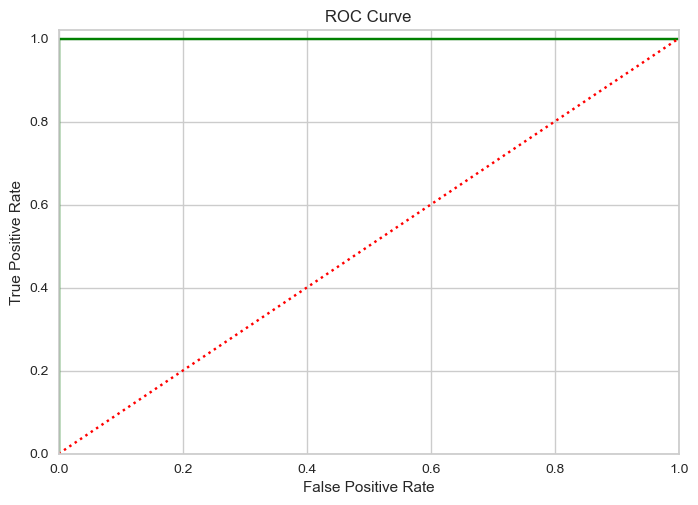

auc: 1.0


In [29]:
fpr,tpr,thres = metrics.roc_curve(train_y,train_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.show()
print("auc:", auc)

**Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.**  
  
Resources Consulted:
- https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
- https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html
- https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.fit.html

In [30]:
plt.close()
print("Parameters and their corresponding coefficients in Logistic Regression:\n")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print( pd.DataFrame({'βi Name': best_features_vanilla,'βi Value':lrm_vanilla.coef_[0]}) )

Parameters and their corresponding coefficients in Logistic Regression:

   βi Name  βi Value
0    std_1    28.391
1    std_2    -8.496
2    max_1    33.185
3    max_2   -57.574
4    max_6    16.403
5    min_7   -41.203
6    max_7     8.611
7    max_8   -17.566
8   max_12   -42.295
9   std_14    -7.216
10  std_18    -9.517
11  max_14   -35.674
12  max_18   -47.025


In [31]:
sm_model = sm.Logit(train_y, train_X).fit(method='lbfgs',maxiter=1000)
print(sm_model.pvalues)
sm_model.summary()

std_1    NaN
std_2    NaN
max_1    NaN
max_2    NaN
max_6    NaN
min_7    NaN
max_7    NaN
max_8    NaN
max_12   NaN
std_14   NaN
std_18   NaN
max_14   NaN
max_18   NaN
dtype: float64


C:\Users\karti\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\karti\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\karti\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         bending_status   No. Observations:                   69
Model:                          Logit   Df Residuals:                       56
Method:                           MLE   Df Model:                           12
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        21:33:20   Log-Likelihood:            -1.4722e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.446e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
std_1         28.9101        nan        nan        nan         nan         nan
std_2         -8.7246        nan        nan        nan         nan         nan
max_1         32.9009        nan        nan        nan         nan         nan
max_2        -57.3621        nan        nan        nan         nan         nan
max_6         16.3132        nan        nan        nan         nan         nan
min_7        -40.4789        nan        nan        nan         nan         nan
max_7          8.3194        nan        nan        nan         nan         nan
max_8        -16.0069        nan        nan        nan         nan         nan
max_12       -41.3277        nan        nan        nan         nan         nan
std_14        -7.3851        nan        nan        nan         nan         nan
std_18        -9.6255        nan        nan        nan         nan         nan
max_14       -36.4775        nan        nan        nan         nan         nan
max_18       -47.4165        nan        nan        nan         nan         nan
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

I believe the Nan values are showing up because the statsmodel algorithm isn't able to reliably converge upon a set of values in order to come up with confidence intervals - that should also explain why the Beta values differ from the coefficient values by so much for every selected feature.

**v. Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.**

In [32]:
test_df_bending = test_df.loc[(test_df['activity'] == 'bending1') | (test_df['activity'] == 'bending2')].drop(
    ['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
test_df_not_bending = test_df.loc[(test_df['activity'] != 'bending1') & (test_df['activity'] != 'bending2')].drop(
['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)

describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=best_l_vanilla)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=best_l_vanilla)

test_X = describe_df[best_features_vanilla]
test_y = describe_df['bending_status']

In [33]:
test_y_predictions = lrm_vanilla.predict(test_X)

print('Accuracy \n', lrm_vanilla.score(test_X,test_y))
print('Confusion Matrix \n', metrics.confusion_matrix(test_y,test_y_predictions))

Accuracy 
 0.7368421052631579
Confusion Matrix 
 [[14  1]
 [ 4  0]]


The accuracy of the test set here is 0.7895, compared to a mean-accuracy of 0.9 across the five-folds of the cross-validation set. I'm confident this is due to some degree of overfitting in the cross-validation, because the 0.9 mean-accuracy came from L=20, meaning we had 3x3x20=180 features to choose from and RFE selected 90 features in total.

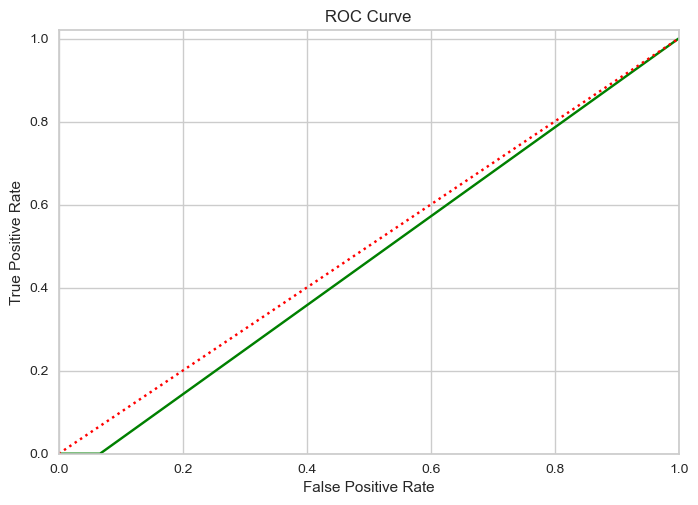

auc: 0.4666666666666667


In [34]:
fpr,tpr,thres = metrics.roc_curve(test_y,test_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.show()
print("auc:", auc)

**vi. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?**


Yes, very much so - we have far too few instances (69 for training, and 19 for testing) but there's 3 (features) x 3 (time series) x l (best split size), so anywhere from 9 to 180 classifications parameters to classify only 69 training points. The logistic regression will thus likely be able to separate each class on some level with many more degrees of freedom remaining in its dimensions/parameters, so there is a lot of resulting instability in the logistic regression parameters. This instability is evidenced by the 
- large amount of warnings when max_iter (for SKLearn)/maxiter (for Statsmodels) is not manually set high, 
- NaN/high p-values for many parameters and the difference in coefficients for the parameters between the Statsmodels Logit function and the SKLearn -> implying a vast and unreliable confidence interval for the coefficients, due to class being very distinctly well-separated so the separation boundary isn't clear to the model
- huge amount of parameters chosen as best features after running RFE/RFECV

**vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.**

The confusion matrices show that the False Positive rate is high, due to only 4 samples that can be classified as True Negative - due to imbalanced classes. We know this to be true too, as only 13 of 88 instances across train and test belong to bending, whereas the rest are not bending.  
  
To correctly perform case-control sampling, I need to ensure that the test set is NOT resampled, and likewise the test set in cross-validation is NOT resampled either, because we want to balance the training sets to better 'educate' our model, while testing its performance against realistic scenarios.

In [35]:
#these lists will give us the best results for all choices of l from 1 to 20
accuracy_list = []
best_features_byaccuracy = []
best_features_bysetsize = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)
    train_X = describe_df.drop('bending_status',axis=1)
    train_y = describe_df['bending_status']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    selected_features_folds = []
    accuracy_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #perform resampling here
        smote = SMOTE()
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)        
        
        #run first logistic regression with recursive feature elimination
        #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
        lrm_one = LogisticRegression(penalty='none', max_iter=1000) 
        selector = RFE(estimator=lrm_one)
        selector = selector.fit(X_train_res,y_train_res)
        best_features = selector.fit(X_train_res,y_train_res).support_
        
        #run second logistic regression with prunes set of features
        #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
        lrm_two = LogisticRegression(penalty='none', max_iter=1000)
        X_train_res = X_train_res.loc[:,best_features]
        X_test = X_test.loc[:,best_features]
        lrm_two.fit(X_train_res,y_train_res)
        
        selected_features_folds.append(X_train_res.columns) #store best features from RFE of each fold
        accuracy_folds.append(lrm_two.score(X_test,y_test)) #store score/mean accuracy of each fold
    
    #we have 5 feature sets and need to choose the most appropriate one for each L
    #we do this by picking highest accuracy cross-val first, and then the smallest set size if there are ties
    k = np.argmax(accuracy_folds)
    max_num = -1
    if type(k) is list: #i.e. >1 of the 5-folds have same highest accuracy
        k_len = [len(selected_features_folds[i]) for i in k]
        s_index = np.argmin(k_len)
        max_num = k[s_index]
    else:
        max_num = k
    
    #another code snippet to see if we want to choose the fold that gives the smallest set size
    len_feature_folds = [len(i) for i in selected_features_folds]
    min_feature_set_size = np.argmin(len_feature_folds)
       
    best_features_byaccuracy.append(selected_features_folds[max_num])
    best_features_bysetsize.append(selected_features_folds[min_feature_set_size])
    accuracy_list.append(np.mean(accuracy_folds))

Identifying new best feature (l,p) and feature set after resampling:

In [36]:
results_df = pd.DataFrame({"L":range(1,21), "Mean 5-Fold Accuracy":accuracy_list, 
                           "Best Accuracy Feature Set":best_features_byaccuracy, 
                           "Smallest Size Feature Set":best_features_bysetsize})
results_df = results_df.set_index("L")
display(results_df)
best_LP = results_df.loc[results_df['Mean 5-Fold Accuracy'] == results_df['Mean 5-Fold Accuracy'].max()]

print('Best L:', best_LP.index[0])
print('\nBest Feature Set (by accuracy from the 5-folds) P:')
print(best_LP['Best Accuracy Feature Set'].iloc[0])
print("\nFeature Set Length:", len(best_LP['Best Accuracy Feature Set'].iloc[0]))

#below code snippet is only relevant/useful for highlighting that a smaller set size exists, and could be useful for further
#analysis if needed
#returns the smallest feature set from the 5-fold validation only if the one with the highest accuracy isn't the smallest size
if len(best_LP['Smallest Size Feature Set'].iloc[0]) != len(best_LP['Best Accuracy Feature Set'].iloc[0]):
    print('\n\n\nBest Feature Set (by set size from the 5-folds) P:')
    print(best_LP['Smallest Size Feature Set'].iloc[0])
    print("\nFeature Set Length:", len(best_LP['Smallest Size Feature Set'].iloc[0]))

l = best_LP.index[0]
p = len(best_LP['Best Accuracy Feature Set'].iloc[0])
best_l_resampling = best_LP.index[0]
best_features_resampling = best_LP['Best Accuracy Feature Set'].iloc[0].tolist()

print("Best (l,p) pair:", (l, p))

Mean 5-Fold Accuracy                          Best Accuracy Feature Set  \
L                                                                             
1               0.800000  Index(['std_1', 'std_2', 'std_6', 'max_2'], dt...   
2               0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...   
3               0.928571  Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...   
4               0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
5               0.928571  Index(['min_1', 'max_2', 'max_6', 'min_7', 'st...   
6               0.914286  Index(['min_1', 'std_2', 'max_1', 'max_2', 'ma...   
7               0.884615  Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...   
8               0.898901  Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...   
9               0.870330  Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...   
10              0.884615  Index(['min_1', 'std_2', 'max_1', 'max_2', 'mi...   
11              0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
12              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...   
13              0.884615  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
14              0.841758  Index(['min_1', 'std_1', 'max_1', 'max_2', 'mi...   
15              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
16              0.841758  Index(['min_1', 'std_1', 'max_1', 'max_6', 'mi...   
17              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'mi...   
18              0.827473  Index(['min_1', 'std_1', 'max_1', 'min_7', 'ma...   
19              0.856044  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   
20              0.870330  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...   

                            Smallest Size Feature Set  
L                                                      
1   Index(['std_1', 'std_2', 'std_6', 'max_2'], dt...  
2   Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...  
3   Index(['min_1', 'std_1', 'std_2', 'max_1', 'ma...  
4   Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
5   Index(['min_1', 'max_2', 'max_6', 'min_7', 'st...  
6   Index(['min_1', 'std_2', 'max_1', 'max_2', 'ma...  
7   Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...  
8   Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...  
9   Index(['min_1', 'std_2', 'max_2', 'max_6', 'mi...  
10  Index(['min_1', 'std_2', 'max_1', 'max_2', 'mi...  
11  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
12  Index(['min_1', 'std_1', 'max_1', 'max_2', 'st...  
13  Index(['min_1', 'max_2', 'max_6', 'std_8', 'ma...  
14  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
15  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
16  Index(['min_1', 'std_1', 'max_1', 'max_6', 'mi...  
17  Index(['min_1', 'std_1', 'max_1', 'max_2', 'mi...  
18  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
19  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...  
20  Index(['min_1', 'std_1', 'max_1', 'max_2', 'ma...

Best L: 3

Best Feature Set (by accuracy from the 5-folds) P:
Index(['min_1', 'std_1', 'std_2', 'max_1', 'max_2', 'min_7', 'max_7', 'max_8',
       'max_12', 'std_14', 'std_18', 'max_14', 'max_18'],
      dtype='object')

Feature Set Length: 13
Best (l,p) pair: (3, 13)


Checking model on train data after resampling:

In [37]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=best_l_resampling)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=best_l_resampling)

train_X = describe_df[best_features_resampling]
train_y = describe_df['bending_status']

#resampling the training dataset
smote = SMOTE()
train_X, train_y = smote.fit_resample(train_X, train_y)   

In [38]:
lrm_resampling = LogisticRegression(penalty='none', max_iter=1000)
lrm_resampling.fit(train_X, train_y)

train_y_predictions = lrm_resampling.predict(train_X)

print('Accuracy \n', lrm_resampling.score(train_X,train_y))
print('Confusion Matrix \n', metrics.confusion_matrix(train_y,train_y_predictions))

Accuracy 
 1.0
Confusion Matrix 
 [[60  0]
 [ 0 60]]


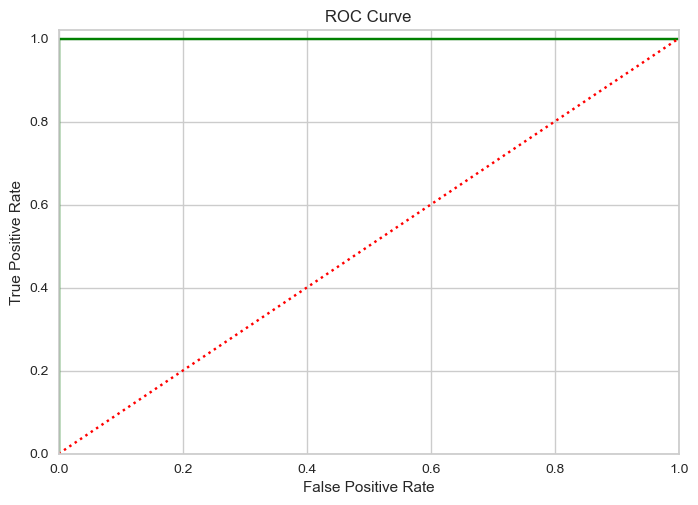

auc: 1.0


In [39]:
fpr,tpr,thres = metrics.roc_curve(train_y,train_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.show()
print("auc:", auc)

In [40]:
plt.close()
print("Parameters and their corresponding coefficients in Logistic Regression:\n")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print( pd.DataFrame({'βi Name': best_features_resampling,'βi Value':lrm_resampling.coef_[0]}) )

Parameters and their corresponding coefficients in Logistic Regression:

   βi Name  βi Value
0    min_1     9.787
1    std_1    46.523
2    std_2    -7.920
3    max_1    44.985
4    max_2   -53.659
5    min_7   -61.350
6    max_7     7.147
7    max_8   -13.280
8   max_12   -46.639
9   std_14    -7.004
10  std_18   -10.481
11  max_14   -35.693
12  max_18   -57.562


In [41]:
sm_model = sm.Logit(train_y, train_X).fit(method='lbfgs', maxiter=1000)
print(sm_model.pvalues)
sm_model.summary()

min_1    NaN
std_1    NaN
std_2    NaN
max_1    NaN
max_2    NaN
min_7    NaN
max_7    NaN
max_8    NaN
max_12   NaN
std_14   NaN
std_18   NaN
max_14   NaN
max_18   NaN
dtype: float64


C:\Users\karti\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\karti\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\karti\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         bending_status   No. Observations:                  120
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                           12
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        21:37:18   Log-Likelihood:            -0.00011319
converged:                       True   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 2.654e-29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
min_1          8.7473        nan        nan        nan         nan         nan
std_1         41.9165        nan        nan        nan         nan         nan
std_2         -7.1331        nan        nan        nan         nan         nan
max_1         40.5177        nan        nan        nan         nan         nan
max_2        -48.3135        nan        nan        nan         nan         nan
min_7        -55.2983        nan        nan        nan         nan         nan
max_7          6.5342        nan        nan        nan         nan         nan
max_8        -11.8401        nan        nan        nan         nan         nan
max_12       -41.8982        nan        nan        nan         nan         nan
std_14        -6.2857        nan        nan        nan         nan         nan
std_18        -9.4226        nan        nan        nan         nan         nan
max_14       -32.0917        nan        nan        nan         nan         nan
max_18       -51.6830        nan        nan        nan         nan         nan
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

Testing classifier performance after resampling on test dataset:

In [42]:
test_df_bending = test_df.loc[(test_df['activity'] == 'bending1') | (test_df['activity'] == 'bending2')].drop(
    ['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
test_df_not_bending = test_df.loc[(test_df['activity'] != 'bending1') & (test_df['activity'] != 'bending2')].drop(
['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)

describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=best_l_resampling)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=best_l_resampling)

test_X = describe_df[best_features_resampling]
test_y = describe_df['bending_status']

In [43]:
test_y_predictions = lrm_resampling.predict(test_X)

print('Accuracy \n', lrm_resampling.score(test_X,test_y))
print('Confusion Matrix \n', metrics.confusion_matrix(test_y,test_y_predictions))

Accuracy 
 0.8421052631578947
Confusion Matrix 
 [[14  1]
 [ 2  2]]


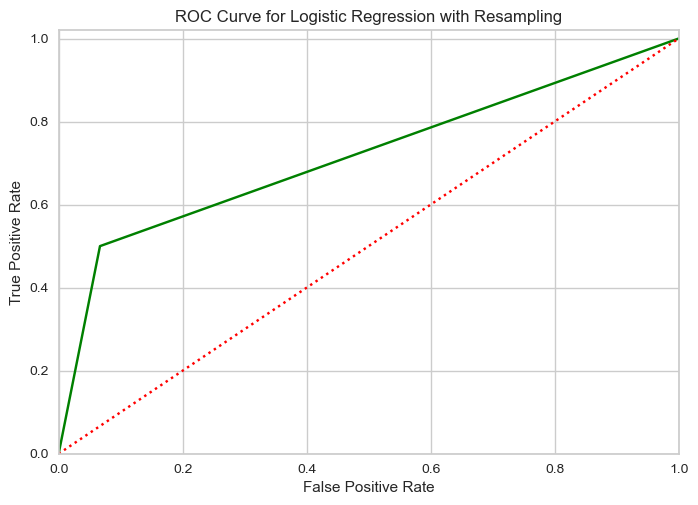

auc: 0.7166666666666667


In [44]:
fpr,tpr,thres = metrics.roc_curve(test_y,test_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with Resampling')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.show()
print("auc:", auc)

Here we achieve the same accuracy, but the auc is slightly worse with resampling than without.

**(b) Binary Classification Using L1-penalized logistic regression**  
  
**i. Repeat 2(a)iii using L1-penalized logistic regression, (For L1-penalized logistic regression, you may want to use normalized/standardized features) 
i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically. (Using the package Liblinear is strongly recommended.)**

If I implemented the previous parts correctly, I don't think I have a whole lot to do here, apart from normalizing/standardizing my data, and maybe exploring LibLinear. Page 63 of Elements of Statistical Learning says that for cases like Ridge Regression, "ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving" - not quite sure if this directly applies towards logistic regression, but I intend to explore with normalization.  
  

My hypothesis is that scaling/normalizing in general for this problem will give better results, because it will make the distance between our classes less separable across features relatively speaking, thereby giving us a smaller range of coefficients that separate our classes, therefore making the logisticRegression more stable. MinMaxScaler() does the same thing as manually normalizing, but I would need to remake the DataFrame with column names and labels, which is a pain in the ass, so I'm just manually gonna normalize the data since the formula is very straightforward. If you follow my "misc_Balodi_Kartik_HW4_withadditionaltests.ipynb" file, you will see that I compare results for normalized vs raw data for all the remaining parts moving forward. I omitted the code for those here, but my key takeaways from that experiment was:
- Normalizing for penalized logistic binary/multinomial regression/classification greatly reduces time taken for convergence. This was evident in multinomial classification especially, as the code block for getting data for each L took nearly an hour without normalizing vs around 10 minutes with normalizing. Also, normalizing produced slightly better results for both cases of logistic regression than not normalizing
- Normalizing made results MUCH worse for Naive Bayes (thought I'm not too sure why)
  
Main Resources Consulted:  
- https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

In [45]:
#normalizing my train/test dataframes

train_df_temp = train_df.drop(['activity','sample'],axis=1)
train_df_normalized = (train_df_temp-train_df_temp.min())/(train_df_temp.max()-train_df_temp.min())
train_df_normalized[['activity','sample']] = train_df[['activity','sample']]

test_df_temp = test_df.drop(['activity','sample'],axis=1)
test_df_normalized = (test_df_temp-test_df_temp.min())/(test_df_temp.max()-test_df_temp.min())
test_df_normalized[['activity','sample']] = test_df[['activity','sample']]

**i. Repeat 2(a)iii using L1-penalized logistic regression, (For L1-penalized logistic regression, you may want to use normalized/standardized features) 
i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically. (Using the package Liblinear is strongly recommended.)**  
  
Main resources consulted:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
- https://www.cs.mcgill.ca/~dprecup/courses/ML/Lectures/ml-lecture02.pdf
- https://stackoverflow.com/questions/46507606/what-does-the-cv-stand-for-in-sklearn-linear-model-logisticregressioncv

L1-penalized logistic regression against _NORMALIZED_ data

In [46]:
train_df_bending_normalized = train_df_normalized.loc[(train_df_normalized['activity'] == 'bending1') | (
    train_df_normalized['activity'] == 'bending2')].drop(['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
train_df_not_bending_normalized = train_df_normalized.loc[(train_df_normalized['activity'] != 'bending1') & (
    train_df_normalized['activity'] != 'bending2')].drop(['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)

#these lists will give us the best results for all choices of l from 1 to 20
l_list = []
accuracy_list = []
auc_list = []
bestscore_weight_lambda_list = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_bending_normalized, stats_type_list, describe_df, bending_status=1, k_splits=l)
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_not_bending_normalized, stats_type_list, describe_df, bending_status=0, k_splits=l)
    train_X = describe_df.drop('bending_status',axis=1)
    train_y = describe_df['bending_status']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    accuracy_folds = []
    auc_folds = []
    bestscore_weight_lambda_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        
        l_list.append(l)
        
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #run L1-penalized Logistic Regression
        lrm_l1 = LogisticRegressionCV(penalty='l1', max_iter=1000, solver='liblinear') 
        lrm_l1.fit(X_train,y_train)
        pred = lrm_l1.predict(X_test)

        accuracy_folds.append(lrm_l1.score(X_test,y_test)) #store score/mean accuracy of each fold
        
        fpr, tpr, thres = metrics.roc_curve(y_test,pred)
        auc_folds.append(metrics.auc(fpr, tpr))
        bestscore_weight_lambda_folds.append(lrm_l1.C_)
    
    
    accuracy_list += accuracy_folds
    auc_list += auc_folds
    bestscore_weight_lambda_list += bestscore_weight_lambda_folds

In [47]:
results_df = pd.DataFrame({'L':l_list, 'Accuracy':accuracy_list, 'AUC':auc_list, 
                           'Best Corresponding Lambda':bestscore_weight_lambda_list})
# I want the highest accuracy first, then AUC, and finally I'll favor the smallest L (lowest parameters/dimensions)
results_df = results_df.sort_values(by=['Accuracy','AUC','L'],ascending=[False,False,True])
results_df

L  Accuracy       AUC Best Corresponding Lambda
10   3  1.000000  1.000000      [166.81005372000558]
13   3  1.000000  1.000000       [21.54434690031882]
20   5  1.000000  1.000000      [166.81005372000558]
25   6  1.000000  1.000000                 [10000.0]
30   7  1.000000  1.000000                 [10000.0]
..  ..       ...       ...                       ...
22   5  0.714286  0.416667       [21.54434690031882]
57  12  0.714286  0.416667       [21.54434690031882]
44   9  0.461538  0.250000      [1291.5496650148827]
6    2  0.428571  0.458333                 [10000.0]
8    2  0.357143  0.416667                 [10000.0]

[100 rows x 4 columns]

In [48]:
results_df.iloc[0]

L                                               3
Accuracy                                      1.0
AUC                                           1.0
Best Corresponding Lambda    [166.81005372000558]
Name: 10, dtype: object

In [49]:
best_lλ = (results_df.iloc[0]['L'],results_df.iloc[0]['Best Corresponding Lambda'][0])
best_l_l1_penalized = results_df.iloc[0]['L']
best_λ_l1_penalized = results_df.iloc[0]['Best Corresponding Lambda'][0]

print("Best (l, λ) pair:", best_lλ)

Best (l, λ) pair: (3, 166.81005372000558)


In [50]:
test_df_normalized

time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0    0.000000   0.769608   0.029655   0.650000   0.044148   0.876623   
1    0.002088   0.769608   0.029655   0.657143   0.000000   0.857143   
2    0.004175   0.769608   0.029655   0.664286   0.044148   0.857143   
3    0.006263   0.774510   0.034483   0.657143   0.072895   0.857143   
4    0.008351   0.774510   0.034483   0.685714   0.000000   0.857143   
..        ...        ...        ...        ...        ...        ...   
475  0.991649   0.705882   0.168966   0.485714   0.523614   0.532468   
476  0.993737   0.673137   0.130345   0.428571   0.251540   0.441558   
477  0.995825   0.647059   0.506897   0.417143   0.322382   0.337662   
478  0.997912   0.620980   0.086207   0.314286   0.632444   0.500000   
479  1.000000   0.602941   0.704138   0.335714   0.111910   0.480519   

     var_rss23  activity    sample  
0     0.133470  bending1  dataset1  
1     0.000000  bending1  dataset1  
2     0.000000  bending1  dataset1  
3     0.000000  bending1  dataset1  
4     0.000000  bending1  dataset1  
..         ...       ...       ...  
475   0.089322   walking  dataset3  
476   0.217659   walking  dataset3  
477   0.585216   walking  dataset3  
478   0.222793   walking  dataset3  
479   0.328542   walking  dataset3  

[9120 rows x 9 columns]

In [51]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending_normalized, stats_type_list, describe_df, bending_status=1, k_splits=best_l_l1_penalized)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending_normalized, stats_type_list, describe_df, bending_status=0, k_splits=best_l_l1_penalized)

train_X = describe_df.drop('bending_status',axis=1)
train_y = describe_df['bending_status']

test_df_bending_normalized = test_df_normalized.loc[(test_df_normalized['activity'] == 'bending1') | (
    test_df_normalized['activity'] == 'bending2')].drop(['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
test_df_not_bending_normalized = test_df_normalized.loc[(test_df_normalized['activity'] != 'bending1') & (
    test_df_normalized['activity'] != 'bending2')].drop(['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)

describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_bending_normalized, stats_type_list, describe_df, bending_status=1, k_splits=best_l_l1_penalized)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_not_bending_normalized, stats_type_list, describe_df, bending_status=0, k_splits=best_l_l1_penalized)

test_X = describe_df.drop('bending_status',axis=1)
test_y = describe_df['bending_status']

In [52]:
lrm_l1 = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', C=best_λ_l1_penalized) 
lrm_l1 = lrm_l1.fit(train_X, train_y)

train_y_predictions = lrm_l1.predict(train_X)
print('Accuracy on train set \n',lrm_l1.score(train_X,train_y))
print('Confusion Matrix of test set \n',metrics.confusion_matrix(train_y,train_y_predictions))

test_y_predictions = lrm_l1.predict(test_X)
print('\nAccuracy on test set \n',lrm_l1.score(test_X,test_y))
print('Confusion Matrix of test set \n',metrics.confusion_matrix(test_y,test_y_predictions))

Accuracy on train set 
 1.0
Confusion Matrix of test set 
 [[60  0]
 [ 0  9]]

Accuracy on test set 
 0.7894736842105263
Confusion Matrix of test set 
 [[15  0]
 [ 4  0]]


**ii. Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?**

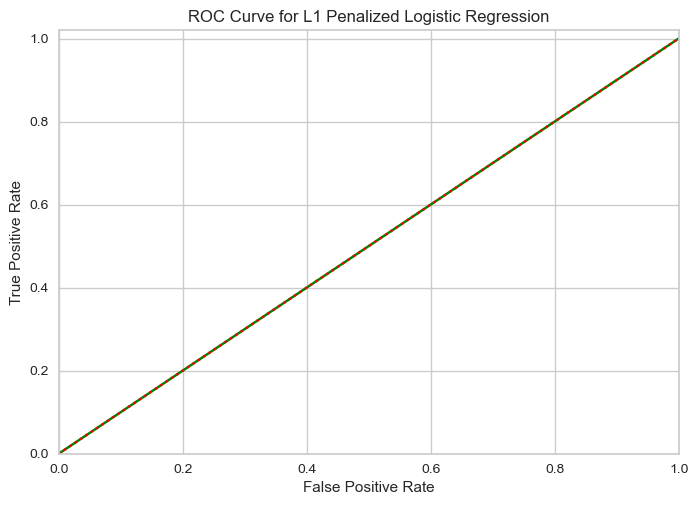

auc: 0.5


In [53]:
fpr,tpr,thres = metrics.roc_curve(test_y,test_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for L1 Penalized Logistic Regression')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.show()
print("auc:", auc)

The initial model (variable selection using RFE/p-values) had a auc of 0.683, so L1-penalized logistic regression performed marginally better on the test set. L1-penalized logistic regression is conceptually more challenging, as we need to cross-validate across λ as well - thankfully the LogisticRegressionCV package does that for us - thus L1-penalized logistic regression proves to be easier to implement as well. NOTE: Rerunning the LogisticRegression cells for L1-penalized logistic regression gives varying results sometimes - I've seen cases with same confusion matrix [[13,2],[2,2]] and same auc = 0.683 as the initial model. This is likely due to instability/lack of convergence in the coefficients of β.

**(c) Multi-class Classification (The Realistic Case)**  
  
**i. Find the best l in the same way as you found it in 2(b)i to build an L1-
penalized multinomial regression model to classify all activities in your training set. (New versions of scikit learn allow using L1-penalty for multinomial regression.) Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible. (For example, the pROC package in R does the job.)**

First, I will need to redefine my splitting function (get_instance_stats_binary_classification_bending_ksplits). Note that I use normalized data, in hopes of speeding up convergence to correct results for multinomial logistic regression/classification, but I use the original data for naive bayes in both cases of c(ii). I try out the opposite case for each of the three models in misc_Balodi_Kartik_HW4_withadditionaltests.ipynb, should you be interested/curious to see some results.  
  
Main resources consulted:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_estimator
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html#multi-class-rocauc-curves

In [54]:
print (train_df['activity'].str.split(';\s*', expand=True).stack().unique())

['bending1' 'bending2' 'cycling' 'lying' 'sitting' 'standing' 'walking']


In [55]:
def multionimial_labeller(train_df, test_df):
    ret_train_df = train_df[['activity']].copy()
    ret_train_df.loc[ret_train_df['activity']=='bending1'] = 1
    ret_train_df.loc[ret_train_df['activity']=='bending2'] = 1
    ret_train_df.loc[ret_train_df['activity']=='cycling'] = 2
    ret_train_df.loc[ret_train_df['activity']=='lying'] = 3
    ret_train_df.loc[ret_train_df['activity']=='sitting'] = 4
    ret_train_df.loc[ret_train_df['activity']=='standing'] = 5
    ret_train_df.loc[ret_train_df['activity']=='walking'] = 6
    
    ret_test_df = test_df[['activity']].copy()
    ret_test_df.loc[ret_test_df['activity']=='bending1'] = 1
    ret_test_df.loc[ret_test_df['activity']=='bending2'] = 1
    ret_test_df.loc[ret_test_df['activity']=='cycling'] = 2
    ret_test_df.loc[ret_test_df['activity']=='lying'] = 3
    ret_test_df.loc[ret_test_df['activity']=='sitting'] = 4
    ret_test_df.loc[ret_test_df['activity']=='standing'] = 5
    ret_test_df.loc[ret_test_df['activity']=='walking'] = 6
    
    res_train_df = train_df.drop(['time','avg_rss13','var_rss13','avg_rss23','activity','sample'],axis=1)
    res_train_df['activity'] = ret_train_df.astype(str).astype(int)
    res_test_df = test_df.drop(['time','avg_rss13','var_rss13','avg_rss23','activity','sample'],axis=1)
    res_test_df['activity'] = ret_test_df.astype(str).astype(int)
    
    return res_train_df, res_test_df

In [56]:
mult_train_df, mult_test_df = multionimial_labeller(train_df, test_df)
mult_test_df

avg_rss12  var_rss12  var_rss23  activity
0        39.25       0.43       1.30         1
1        39.25       0.43       0.00         1
2        39.25       0.43       0.00         1
3        39.50       0.50       0.00         1
4        39.50       0.50       0.00         1
..         ...        ...        ...       ...
475      36.00       2.45       0.87         6
476      34.33       1.89       2.12         6
477      33.00       7.35       5.70         6
478      31.67       1.25       2.17         6
479      30.75      10.21       3.20         6

[9120 rows x 4 columns]

In [57]:
def get_instance_stats_mult_classification_ksplits(
    input_df, stats_type_list, k_splits):
    
    describe_df = pd.DataFrame()
    step_size = 480//k_splits #note here that k_splits must be a divisor of 480
    
    #first split the dataframe into equal length time series
    splitted_input_df_list = [pd.DataFrame() for j in range(k_splits)]
    for i in range(0,len(input_df),480):
        for j in range(k_splits):
            df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < i+(j+1)*step_size) ]
            if j == k_splits-1:
                df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < 480) ]
            splitted_input_df_list[j] = pd.concat([splitted_input_df_list[j],df],axis=0)
    
    #repeat step from a(i) with each split df
    for i in range(len(splitted_input_df_list)): #for each equal-length i= to i=k time-series
        split_df = splitted_input_df_list[i]
        
        #accounts for any uneven splitting for the final split of the initial time series
        step_size2 = 480//k_splits
        if i == k_splits-1:
            step_size2 = 480//k_splits + 480%k_splits
        
        temp_df = pd.DataFrame()

        for j in range(0,len(split_df), step_size2): #for each of the j instances in the equal-length time series
            
            current_activity = split_df.iloc[j:j+step_size2]['activity'].mean()
            second_split_df = split_df.iloc[j:j+step_size2].drop(['activity'],axis=1)
            
            
            instance_stats = second_split_df.describe()
            instance_df = pd.DataFrame()
            
            for k in stats_type_list: #for each stat we demand
                single_stats = pd.DataFrame(data=[instance_stats.loc[k].tolist()],
                                            columns=[k+"_"+str(l+i*6) for l in [1,2,6]]) #label ith split as 'split_i'
                instance_df = pd.concat([instance_df,single_stats],axis=1) #concat each stat by column
            
            instance_df['activity'] = current_activity
            temp_df = pd.concat([temp_df,instance_df],ignore_index=True) #concat here by row corresponding to each instance
            
        if i != len(splitted_input_df_list)-1:
            temp_df = temp_df.drop(['activity'],axis=1)
        describe_df = pd.concat([describe_df,temp_df],axis=1) #concat by column to append results of each instance columnwise
    
    return describe_df

In [58]:
#normalizing my train/test dataframes
mult_train_df_temp = mult_train_df.drop(['activity'],axis=1)
mult_train_df_normalized = (mult_train_df_temp-mult_train_df_temp.min())/(mult_train_df_temp.max()-mult_train_df_temp.min())
mult_train_df_normalized['activity'] = mult_train_df['activity']

mult_test_df_temp = mult_test_df.drop(['activity'],axis=1)
mult_test_df_normalized = (mult_test_df_temp-mult_test_df_temp.min())/(mult_test_df_temp.max()-mult_test_df_temp.min())
mult_test_df_normalized['activity'] = mult_test_df['activity']

In [59]:
#these lists will give us the best results for all choices of l from 1 to 20
l_list = []
accuracy_list = []
bestscore_weight_lambda_list = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df_normalized, stats_type_list, k_splits=l)
    
    train_X = describe_df.drop('activity',axis=1)
    train_y = describe_df['activity']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    accuracy_folds = []
    bestscore_weight_lambda_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        
        l_list.append(l)
        
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #run L1-penalized Logistic Regression
        lrm_l1_multinomial = LogisticRegressionCV(penalty='l1', max_iter=1000, solver='saga', multi_class='multinomial') 
        lrm_l1_multinomial.fit(X_train,y_train)
        pred = lrm_l1_multinomial.predict(X_test)

        accuracy_folds.append(lrm_l1_multinomial.score(X_test,y_test)) #store score/mean accuracy of each fold
        bestscore_weight_lambda_folds.append(lrm_l1_multinomial.C_)
    
    
    accuracy_list += accuracy_folds
    bestscore_weight_lambda_list += bestscore_weight_lambda_folds

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

In [60]:
results_df = pd.DataFrame({'L':l_list, 'Accuracy':accuracy_list, 'Best Corresponding Lambda':bestscore_weight_lambda_list})
# I want the highest accuracy first, then AUC, and finally I'll favor the smallest L (lowest parameters/dimensions)
results_df = results_df.sort_values(by=['Accuracy','L'],ascending=[False,True])
results_df

L  Accuracy                          Best Corresponding Lambda
12   3  0.857143  [21.54434690031882, 21.54434690031882, 21.5443...
9    2  0.846154  [166.81005372000558, 166.81005372000558, 166.8...
69  14  0.846154  [166.81005372000558, 166.81005372000558, 166.8...
79  16  0.846154  [21.54434690031882, 21.54434690031882, 21.5443...
17   4  0.785714  [21.54434690031882, 21.54434690031882, 21.5443...
..  ..       ...                                                ...
83  17  0.500000  [166.81005372000558, 166.81005372000558, 166.8...
88  18  0.500000  [166.81005372000558, 166.81005372000558, 166.8...
98  20  0.500000  [166.81005372000558, 166.81005372000558, 166.8...
6    2  0.428571  [166.81005372000558, 166.81005372000558, 166.8...
36   8  0.428571  [21.54434690031882, 21.54434690031882, 21.5443...

[100 rows x 3 columns]

In [61]:
results_df.iloc[0]

L                                                                            3
Accuracy                                                              0.857143
Best Corresponding Lambda    [21.54434690031882, 21.54434690031882, 21.5443...
Name: 12, dtype: object

In [62]:
best_lλ = (results_df.iloc[0]['L'],results_df.iloc[0]['Best Corresponding Lambda'][0])
best_l_l1_penalized_mult = results_df.iloc[0]['L']
best_λ_l1_penalized_mult = results_df.iloc[0]['Best Corresponding Lambda'][0]

print("Best (l, λ) pair:", best_lλ)

Best (l, λ) pair: (3, 21.54434690031882)


In [63]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df_normalized, stats_type_list, 
                                                             k_splits=best_l_l1_penalized_mult)
train_X = describe_df.drop('activity',axis=1)
train_y = describe_df['activity']

describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_test_df_normalized, stats_type_list, 
                                                             k_splits=best_l_l1_penalized_mult)
test_X = describe_df.drop('activity',axis=1)
test_y = describe_df['activity']

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy on train set 
 0.927536231884058
Train Confusion Matrix 
 [[ 8  0  0  0  1  0]
 [ 0 12  0  0  0  0]
 [ 1  0 11  0  0  0]
 [ 1  0  0  9  2  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


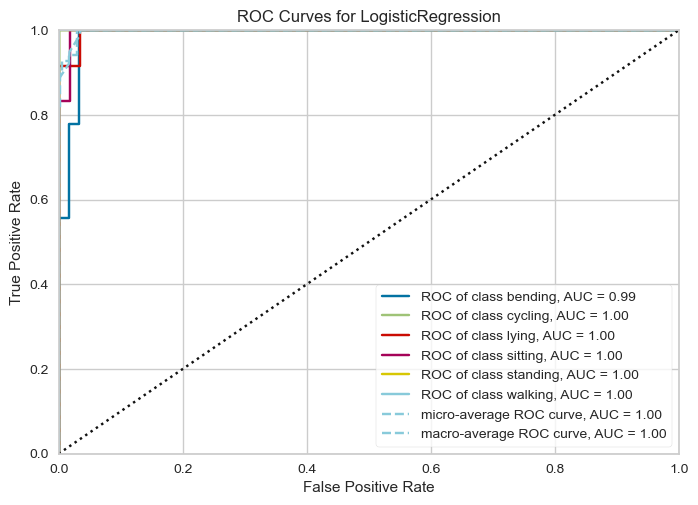


Accuracy on test set 
 0.42105263157894735
Test Confusion Matrix 
 [[0 0 0 1 3 0]
 [0 2 0 0 0 1]
 [0 0 0 1 2 0]
 [0 0 0 1 2 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


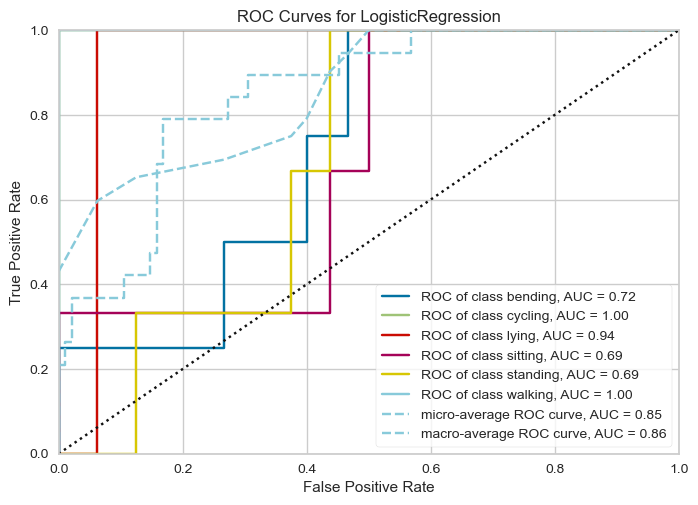

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [64]:
lrm_l1_multinomial = LogisticRegression(penalty='l1', max_iter=1000, solver='saga', multi_class='multinomial', 
                                          C=best_λ_l1_penalized_mult) 
lrm_l1_multinomial.fit(train_X, train_y)

train_y_predictions = lrm_l1_multinomial.predict(train_X)
train_y_proba = lrm_l1_multinomial.predict_proba(train_X)
print('Accuracy on train set \n',lrm_l1_multinomial.score(train_X,train_y))
print('Train Confusion Matrix \n',metrics.confusion_matrix(train_y,train_y_predictions))
visualizer = ROCAUC(lrm_l1_multinomial, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(train_X, train_y)
visualizer.show()

test_y_predictions = lrm_l1_multinomial.predict(test_X)
test_y_proba = lrm_l1_multinomial.predict_proba(test_X)
print('\nAccuracy on test set \n',lrm_l1_multinomial.score(test_X,test_y))
print('Test Confusion Matrix \n',metrics.confusion_matrix(test_y,test_y_predictions))
visualizer = ROCAUC(lrm_l1_multinomial, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show()

**ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.**  
  
Main resources consulted:
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

Gaussian prior, without normalization

In [65]:
#these lists will give us the best results for all choices of l from 1 to 20
l_list = []
# l_list = [l for l in range(1,21)]
accuracy_list = []
mean_l_performance = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df, stats_type_list, k_splits=l)
    
    train_X = describe_df.drop('activity',axis=1)
    train_y = describe_df['activity']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    accuracy_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        l_list.append(l)
        
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #run Gaussian Naive Bayes
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)

        pred = gnb.predict(X_test)

        accuracy_folds.append(gnb.score(X_test,y_test)) #store score/mean accuracy of each fold    
    
#     accuracy_list.append(np.mean(accuracy_folds))
    accuracy_list += accuracy_folds
    mean_l_performance.append(np.mean(accuracy_folds))

In [66]:
results_df = pd.DataFrame({'L':[l for l in range(1,21)], 'Mean Accuracy':mean_l_performance})
# I want the highest accuracy first, then AUC, and finally I'll favor the smallest L (lowest parameters/dimensions)
results_df = results_df.sort_values(by=['Mean Accuracy','L'],ascending=[False,True])
results_df

L  Mean Accuracy
1    2       0.712088
0    1       0.694505
2    3       0.681319
6    7       0.652747
7    8       0.637363
9   10       0.594505
3    4       0.578022
8    9       0.578022
10  11       0.578022
4    5       0.564835
19  20       0.564835
12  13       0.563736
13  14       0.562637
5    6       0.551648
14  15       0.551648
11  12       0.549451
15  16       0.549451
17  18       0.535165
18  19       0.535165
16  17       0.506593

In [67]:
results_df.iloc[0]

L                2.000000
Mean Accuracy    0.712088
Name: 1, dtype: float64

In [68]:
best_l_gnb = int(results_df.iloc[0]['L'])

print("Best l Gaussian NB:", str((np.argmax(accuracy_list)+1)//5+1) )
print("Best mean-performance l Gaussian NB:", str(np.argmax(mean_l_performance)+1))

Best l Gaussian NB: 1
Best mean-performance l Gaussian NB: 2


In [69]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df, stats_type_list, 
                                                             k_splits=best_l_gnb)
train_X = describe_df.drop('activity',axis=1)
train_y = describe_df['activity']

describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_test_df, stats_type_list, 
                                                             k_splits=best_l_gnb)
test_X = describe_df.drop('activity',axis=1)
test_y = describe_df['activity']

Accuracy on train set 
 0.8695652173913043
Train Confusion Matrix 
 [[ 5  0  1  0  3  0]
 [ 0 12  0  0  0  0]
 [ 1  0 11  0  0  0]
 [ 1  0  1  9  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


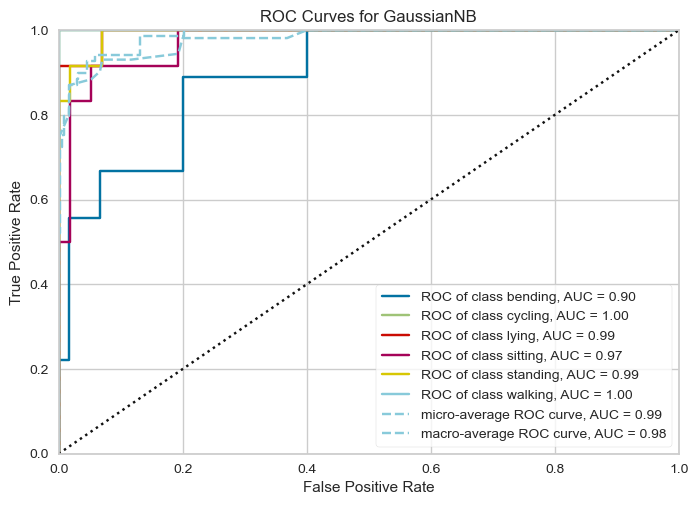


Accuracy on test set 
 0.6842105263157895
Test Confusion Matrix 
 [[2 0 1 0 1 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 2 0 0 0 1]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


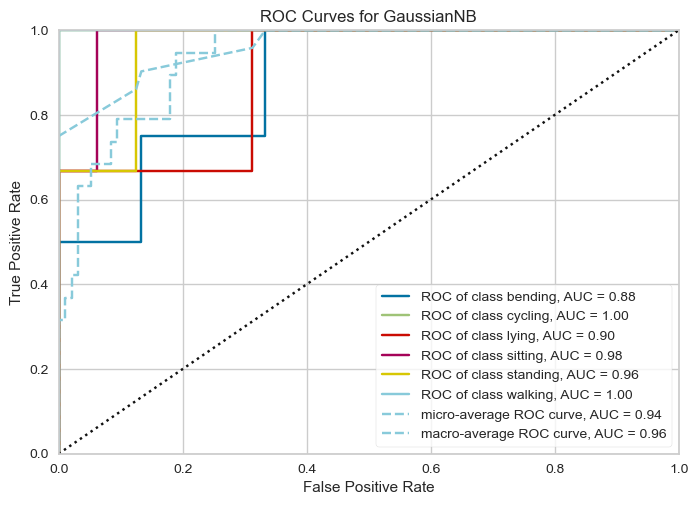

<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [70]:
gnb = GaussianNB()
gnb.fit(train_X, train_y)

train_y_predictions = gnb.predict(train_X)
train_y_proba = gnb.predict_proba(train_X)
print('Accuracy on train set \n',gnb.score(train_X,train_y))
print('Train Confusion Matrix \n',metrics.confusion_matrix(train_y,train_y_predictions))
visualizer = ROCAUC(gnb, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(train_X, train_y)
visualizer.show()

test_y_predictions = gnb.predict(test_X)
test_y_proba = gnb.predict_proba(test_X)
print('\nAccuracy on test set \n',gnb.score(test_X,test_y))
print('Test Confusion Matrix \n',metrics.confusion_matrix(test_y,test_y_predictions))
visualizer = ROCAUC(gnb, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show()

Multinomial prior, without normalization

In [71]:
#these lists will give us the best results for all choices of l from 1 to 20
l_list = []
# l_list = [l for l in range(1,21)]
accuracy_list = []
mean_l_performance = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df, stats_type_list, k_splits=l)
    
    train_X = describe_df.drop('activity',axis=1)
    train_y = describe_df['activity']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
    skf = StratifiedKFold(n_splits=5)
    
    #for storing results for each fold
    accuracy_folds = []

    for train_index,test_index in skf.split(train_X,train_y):
        l_list.append(l)

        
        X_train, X_test = train_X.iloc[train_index.tolist(),:], train_X.iloc[test_index.tolist(),:]
        y_train, y_test = train_y[train_index.tolist()], train_y[test_index.tolist()]
        
        #run Multinomial Naive Bayes
        mnb = MultinomialNB()
        mnb.fit(X_train, y_train)

        pred = mnb.predict(X_test)

        accuracy_folds.append(mnb.score(X_test,y_test)) #store score/mean accuracy of each fold    
    
#     accuracy_list.append(np.mean(accuracy_folds))
    accuracy_list += accuracy_folds
    mean_l_performance.append(np.mean(accuracy_folds))

In [72]:
results_df = pd.DataFrame({'L':[l for l in range(1,21)], 'Mean Accuracy':mean_l_performance})
# I want the highest accuracy first, then AUC, and finally I'll favor the smallest L (lowest parameters/dimensions)
results_df = results_df.sort_values(by=['Mean Accuracy','L'],ascending=[False,True])
results_df

L  Mean Accuracy
4    5       0.637363
8    9       0.623077
10  11       0.623077
16  17       0.623077
9   10       0.608791
17  18       0.607692
6    7       0.593407
15  16       0.580220
18  19       0.580220
7    8       0.579121
12  13       0.579121
13  14       0.579121
14  15       0.579121
1    2       0.565934
19  20       0.564835
3    4       0.562637
11  12       0.549451
5    6       0.548352
2    3       0.507692
0    1       0.435165

In [73]:
results_df.iloc[0]

L                5.000000
Mean Accuracy    0.637363
Name: 4, dtype: float64

In [74]:
best_l_mnb = int(results_df.iloc[0]['L'])

print("Best l Multinomial NB:", str( (np.argmax(accuracy_list)+1)//5+1 ))
print("Best mean-performance l Multinomial NB:", str(np.argmax(mean_l_performance)+1))

Best l Multinomial NB: 4
Best mean-performance l Multinomial NB: 5


In [75]:
describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_train_df, stats_type_list, 
                                                             k_splits=best_l_mnb)
train_X = describe_df.drop('activity',axis=1)
train_y = describe_df['activity']

describe_df = pd.DataFrame()
describe_df = get_instance_stats_mult_classification_ksplits(mult_test_df, stats_type_list, 
                                                             k_splits=best_l_mnb)
test_X = describe_df.drop('activity',axis=1)
test_y = describe_df['activity']

Accuracy on train set 
 0.7681159420289855
Train Confusion Matrix 
 [[ 5  0  1  1  2  0]
 [ 0 11  0  0  0  1]
 [ 0  0  9  3  0  0]
 [ 2  0  4  5  1  0]
 [ 0  0  1  0 11  0]
 [ 0  0  0  0  0 12]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


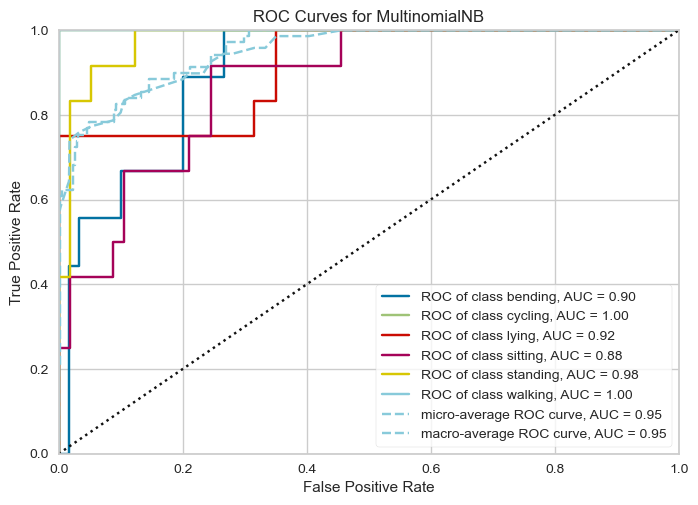


Accuracy on test set 
 0.5789473684210527
Test Confusion Matrix 
 [[0 2 2 0 0 0]
 [0 3 0 0 0 0]
 [0 0 2 1 0 0]
 [0 0 1 1 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


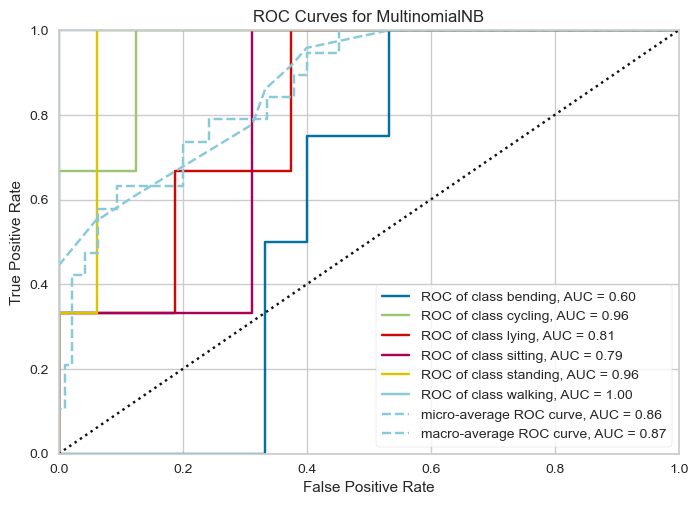

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [76]:
mnb = MultinomialNB()
mnb.fit(train_X, train_y)

train_y_predictions = mnb.predict(train_X)
train_y_proba = mnb.predict_proba(train_X)
print('Accuracy on train set \n',mnb.score(train_X,train_y))
print('Train Confusion Matrix \n',metrics.confusion_matrix(train_y,train_y_predictions))
visualizer = ROCAUC(mnb, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(train_X, train_y)
visualizer.show()

test_y_predictions = mnb.predict(test_X)
test_y_proba = mnb.predict_proba(test_X)
print('\nAccuracy on test set \n',mnb.score(test_X,test_y))
print('Test Confusion Matrix \n',metrics.confusion_matrix(test_y,test_y_predictions))
visualizer = ROCAUC(mnb, classes=["bending","cycling","lying","sitting","standing","walking"])
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show()